# Importowanie bibliotek

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imgaug import augmenters as iaa
import imgaug as ia
from random import shuffle
import cv2
import numpy as np

from DataService import DataService
from EnvironmentSettings import EnvironmentSettings

import matplotlib.pyplot as plt

# Ustawianie ścieżek do zasobów

W oddzielnej klasie *EnvironmentSettings* przypisuje do zmiennych ścieżki, które odnoszą się do takich zasobów jak zbiór testowy, treningowy, labelki itd

In [2]:
ENV_SETTINGS = EnvironmentSettings("HOME")

# Wczytywanie danych

In [3]:
train_files = glob(ENV_SETTINGS.train + '/*.' + ENV_SETTINGS.image_extension)
print("labeled files size :", len(train_files))

df_train = pd.read_csv(ENV_SETTINGS.labels)
df_train.head()
FILE_LABELS = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}

TRAIN_SET, TEST_SET = train_test_split(train_files, test_size = 0.1, random_state = 42)
print("training size :", len(TRAIN_SET))
print("testing size :", len(TEST_SET))

labeled files size : 220025
training size : 198022
testing size : 22003


# Generowanie danych (w batch'ach)

In [4]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_id_from_file_path(file_path):
    #return os.path.basename(file_path)
    return file_path.split(os.path.sep)[-1].replace('.' + ENV_SETTINGS.image_extension, '')

def data_gen(list_files, id_label_map, batch_size):
    while True:
        #shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]

            yield np.array(X), np.array(Y)


# Generowanie wykresów metryk

In [5]:
def show_final_history(history):
    fig, ax = plt.subplots(2, 2, figsize=(15,5))
    ax[0][0].set_title('loss')
    ax[0][0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0][0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0][1].set_title('accuracy')
    ax[0][1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[0][1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[1][0].set_title('F1')
    ax[1][0].plot(history.epoch, history.history["get_f1"], label="Train F1")
    ax[1][0].plot(history.epoch, history.history["val_get_f1"], label="Validation F1")
    ax[1][1].set_title('Auc')
    ax[1][1].plot(history.epoch, history.history["get_auc"], label="Train Auc")
    ax[1][1].plot(history.epoch, history.history["val_get_auc"], label="Validation Auc")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    plt.show()

# Metryki F1 oraz Auc

In [6]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

# AUC for a binary classifier (https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41015)
def get_auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)
    
#---------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N

#----------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P
    

# Parametry uczenia

In [7]:
HEIGHT = WIDTH = 96
CHANNEL = 3
BATCH_SIZE = 128
EPOCHS = 1000

# Zdefiniowanie modelu

In [8]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(HEIGHT, WIDTH ,CHANNEL)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Kompilacja modelu

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', get_f1, get_auc])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

# Start nauki modelu

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ENV_SETTINGS.checkpoint,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit_generator(
    data_gen(TRAIN_SET, FILE_LABELS, BATCH_SIZE),
    steps_per_epoch=len(TRAIN_SET) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=data_gen(TEST_SET, FILE_LABELS, BATCH_SIZE),
    validation_steps=len(TEST_SET) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1547 steps, validate for 171 steps
Epoch 1/1000
1546/1547 [============================>.] - ETA: 0s - loss: 1.6005 - accuracy: 0.7655 - get_f1: 0.6431 - get_auc: 0.6248WARNING:tensorflow:From C:\Users\neeke\anaconda3\envs\tensorflow2\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\MyFiles\Thesis\Project\outputs\checkpoints\assets
1547/1547 [==============================] - 779s 503ms/step - loss: 1.5998 - accuracy: 0.7655 - get_f1: 0.6430 - get_auc: 0.6248 - val_loss: 0.4393 - val_accuracy: 0.7841 - val_get_f1: 0.6854 - val_get_auc: 0.6622
Epoch 2/1

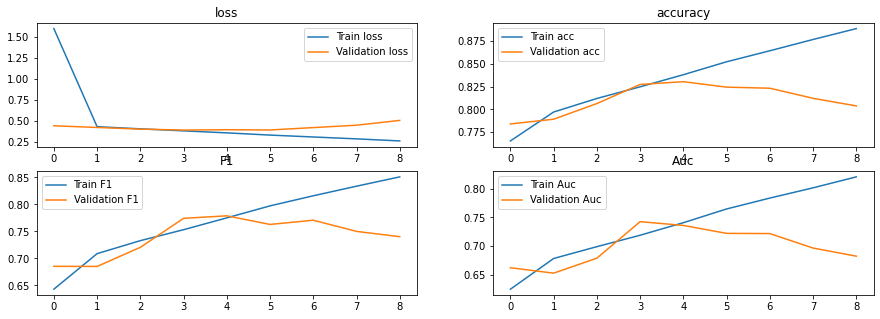

In [12]:
show_final_history(history)

# Zbudowanie i nauka bardziej zaawansowanego modelu

In [13]:
model2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(HEIGHT, WIDTH ,CHANNEL)),
    Conv2D(16, 3, padding='same', activation='relu'),
    Dropout(0.5),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Dropout(0.5),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    Dropout(0.5),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', get_f1, get_auc])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)       

In [15]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ENV_SETTINGS.checkpoint,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history2 = model2.fit_generator(
    data_gen(TRAIN_SET, FILE_LABELS, BATCH_SIZE),
    steps_per_epoch=len(TRAIN_SET) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=data_gen(TEST_SET, FILE_LABELS, BATCH_SIZE),
    validation_steps=len(TEST_SET) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1547 steps, validate for 171 steps
Epoch 1/1000
1547/1547 [==============================] - 1020s 660ms/step - loss: 0.4415 - accuracy: 0.7902 - get_f1: 0.6974 - get_auc: 0.6758 - val_loss: 0.5232 - val_accuracy: 0.8050 - val_get_f1: 0.7421 - val_get_auc: 0.7966
Epoch 2/1000
1547/1547 [==============================] - 987s 638ms/step - loss: 0.4186 - accuracy: 0.8026 - get_f1: 0.7185 - get_auc: 0.6929 - val_loss: 0.4656 - val_accuracy: 0.8138 - val_get_f1: 0.7577 - val_get_auc: 0.7682
Epoch 3/1000
1547/1547 [==============================] - 965s 624ms/step - loss: 0.3904 - accuracy: 0.8186 - get_f1: 0.7448 - get_auc: 0.7188 - val_loss: 0.4485 - val_accuracy: 0.8119 - val_get_f1: 0.7433 - val_get_auc: 0.7303
Epoch 4/1000
1547/1547 [==============================] - 983s 635ms/step - loss: 0.3491 - accuracy: 0.8423 - get_f1: 0.7813 - get_auc: 0.7608 - val_loss: 0.3763 - val_accuracy: 0.8434 - val_get_f1: 0.7826 - val_get_auc:

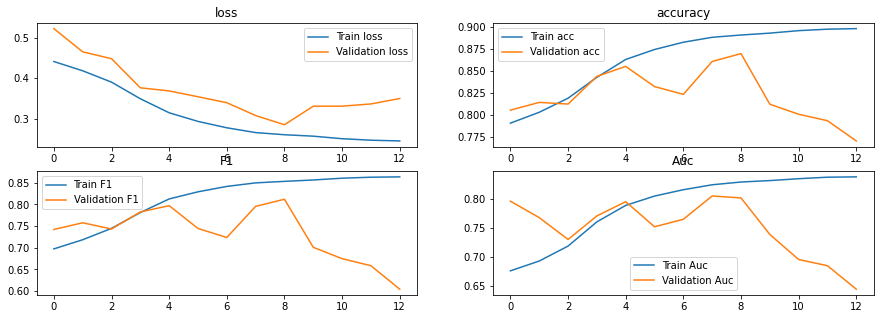

In [16]:
show_final_history(history2)

# Dostosowywanie parametrów

In [17]:
from kerastuner import HyperModel

In [22]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'conv_1',
                    values=[16, 32],
                    default=16,
                ),
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(MaxPooling2D())
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.5,
                step=0.1,
            ))
        )
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'conv_2',
                    values=[32, 64],
                    default=32,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D())
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.50,
                step=0.1,
            ))
        )
        model.add(
            Conv2D(
                filters=64,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'conv_3',
                    values=[64, 128],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D())
        model.add(
            Dropout(rate=hp.Float(
                'dropout_3',
                min_value=0.0,
                max_value=0.5,
                default=0.5,
                step=0.1,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=128,
                    max_value=1024,
                    step=128,
                    default=512
                ),
                activation='relu'
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_4',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.5,
                    step=0.1
                )
            )
        )
        model.add(Dense(1))

        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        return model

hypermodel = CNNHyperModel(input_shape=(HEIGHT, WIDTH, CHANNEL))

In [23]:
from kerastuner import RandomSearch

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter-tuning1')

In [24]:
tuner.search_space_summary()

In [25]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
tuner.search(
    data_gen(TRAIN_SET[:51200], FILE_LABELS, BATCH_SIZE), 
    steps_per_epoch=len(TRAIN_SET[:51200]) // BATCH_SIZE,
    epochs=50, 
    validation_data=data_gen(TEST_SET, FILE_LABELS, BATCH_SIZE),
    validation_steps=len(TEST_SET) // BATCH_SIZE,
    callbacks=[early_stopping_callback],
    verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 1.0424 - accuracy: 0.6990 - val_loss: 0.4812 - val_accuracy: 0.7877
Epoch 2/50
400/400 - 23s - loss: 0.4659 - accuracy: 0.7725 - val_loss: 0.4576 - val_accuracy: 0.7929
Epoch 3/50
400/400 - 22s - loss: 0.4546 - accuracy: 0.7794 - val_loss: 0.4332 - val_accuracy: 0.7921
Epoch 4/50
400/400 - 22s - loss: 0.4444 - accuracy: 0.7856 - val_loss: 0.4265 - val_accuracy: 0.8016
Epoch 5/50
400/400 - 23s - loss: 0.4373 - accuracy: 0.7912 - val_loss: 0.4314 - val_accuracy: 0.8044
Epoch 6/50
400/400 - 22s - loss: 0.4336 - accuracy: 0.7937 - val_loss: 0.4120 - val_accuracy: 0.7941
Epoch 7/50
400/400 - 22s - loss: 0.4245 - accuracy: 0.7979 - val_loss: 0.4057 - val_accuracy: 0.8013
Epoch 8/50
400/400 - 23s - loss: 0.4152 - accuracy: 0.8050 - val_loss: 0.3928 - val_accuracy: 0.8060
Epoch 9/50
400/400 - 23s - loss: 0.4034 - accuracy: 0.8121 - val_loss: 0.3841 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 27s - loss: 1.5656 - accuracy: 0.7185 - val_loss: 0.5198 - val_accuracy: 0.7699
Epoch 2/50
400/400 - 26s - loss: 0.4530 - accuracy: 0.7795 - val_loss: 0.4593 - val_accuracy: 0.8032
Epoch 3/50
400/400 - 26s - loss: 0.4375 - accuracy: 0.7884 - val_loss: 0.4269 - val_accuracy: 0.8221
Epoch 4/50
400/400 - 27s - loss: 0.4198 - accuracy: 0.8000 - val_loss: 0.4287 - val_accuracy: 0.8330
Epoch 5/50
400/400 - 25s - loss: 0.3988 - accuracy: 0.8151 - val_loss: 0.3924 - val_accuracy: 0.8425
Epoch 6/50
400/400 - 25s - loss: 0.3825 - accuracy: 0.8243 - val_loss: 0.3671 - val_accuracy: 0.8396
Epoch 7/50
400/400 - 25s - loss: 0.3703 - accuracy: 0.8302 - val_loss: 0.3692 - val_accuracy: 0.8554
Epoch 8/50
400/400 - 25s - loss: 0.3556 - accuracy: 0.8387 - val_loss: 0.3364 - val_accuracy: 0.8609
Epoch 9/50
400/400 - 25s - loss: 0.3426 - accuracy: 0.8448 - val_loss: 0.3356 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 26s - loss: 1.6964 - accuracy: 0.7173 - val_loss: 0.4907 - val_accuracy: 0.7704
Epoch 2/50
400/400 - 24s - loss: 0.4630 - accuracy: 0.7759 - val_loss: 0.4545 - val_accuracy: 0.7903
Epoch 3/50
400/400 - 23s - loss: 0.4441 - accuracy: 0.7881 - val_loss: 0.4432 - val_accuracy: 0.7703
Epoch 4/50
400/400 - 23s - loss: 0.4313 - accuracy: 0.7954 - val_loss: 0.4464 - val_accuracy: 0.7764
Epoch 5/50
400/400 - 24s - loss: 0.4182 - accuracy: 0.8025 - val_loss: 0.4029 - val_accuracy: 0.8206
Epoch 6/50
400/400 - 24s - loss: 0.4130 - accuracy: 0.8060 - val_loss: 0.3862 - val_accuracy: 0.8209
Epoch 7/50
400/400 - 24s - loss: 0.3861 - accuracy: 0.8213 - val_loss: 0.3946 - val_accuracy: 0.8230
Epoch 8/50
400/400 - 24s - loss: 0.3685 - accuracy: 0.8314 - val_loss: 0.3865 - val_accuracy: 0.8262
Epoch 9/50
400/400 - 24s - loss: 0.3594 - accuracy: 0.8355 - val_loss: 0.3561 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3732 - accuracy: 0.6738 - val_loss: 0.5722 - val_accuracy: 0.7593
Epoch 2/50
400/400 - 21s - loss: 0.4729 - accuracy: 0.7673 - val_loss: 0.5110 - val_accuracy: 0.7844
Epoch 3/50
400/400 - 21s - loss: 0.4617 - accuracy: 0.7756 - val_loss: 0.5327 - val_accuracy: 0.7831
Epoch 4/50
400/400 - 21s - loss: 0.4532 - accuracy: 0.7818 - val_loss: 0.6070 - val_accuracy: 0.7574
Epoch 5/50
400/400 - 21s - loss: 0.4467 - accuracy: 0.7865 - val_loss: 0.5486 - val_accuracy: 0.7824
Epoch 6/50
400/400 - 21s - loss: 0.4401 - accuracy: 0.7902 - val_loss: 0.5244 - val_accuracy: 0.7869
Epoch 7/50
400/400 - 21s - loss: 0.4296 - accuracy: 0.7944 - val_loss: 0.4635 - val_accuracy: 0.8085
Epoch 8/50
400/400 - 21s - loss: 0.4241 - accuracy: 0.7981 - val_loss: 0.5186 - val_accuracy: 0.7887
Epoch 9/50
400/400 - 21s - loss: 0.4192 - accuracy: 0.8013 - val_loss: 0.4843 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.5758 - accuracy: 0.6741 - val_loss: 0.4732 - val_accuracy: 0.7520
Epoch 2/50
400/400 - 21s - loss: 0.4799 - accuracy: 0.7638 - val_loss: 0.4975 - val_accuracy: 0.7856
Epoch 3/50
400/400 - 21s - loss: 0.4647 - accuracy: 0.7741 - val_loss: 0.5196 - val_accuracy: 0.7904
Epoch 4/50
400/400 - 21s - loss: 0.4551 - accuracy: 0.7797 - val_loss: 0.5034 - val_accuracy: 0.7948
Epoch 5/50
400/400 - 21s - loss: 0.4458 - accuracy: 0.7854 - val_loss: 0.4709 - val_accuracy: 0.8048
Epoch 6/50
400/400 - 21s - loss: 0.4413 - accuracy: 0.7874 - val_loss: 0.5339 - val_accuracy: 0.7947
Epoch 7/50
400/400 - 21s - loss: 0.4353 - accuracy: 0.7926 - val_loss: 0.4738 - val_accuracy: 0.8090
Epoch 8/50
400/400 - 21s - loss: 0.4283 - accuracy: 0.7955 - val_loss: 0.4665 - val_accuracy: 0.8119
Epoch 9/50
400/400 - 21s - loss: 0.4254 - accuracy: 0.7977 - val_loss: 0.4789 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 0.7765 - accuracy: 0.7385 - val_loss: 0.4907 - val_accuracy: 0.7668
Epoch 2/50
400/400 - 21s - loss: 0.4586 - accuracy: 0.7764 - val_loss: 0.4965 - val_accuracy: 0.7191
Epoch 3/50
400/400 - 22s - loss: 0.4379 - accuracy: 0.7912 - val_loss: 0.4127 - val_accuracy: 0.8002
Epoch 4/50
400/400 - 22s - loss: 0.4131 - accuracy: 0.8087 - val_loss: 0.4070 - val_accuracy: 0.8218
Epoch 5/50
400/400 - 22s - loss: 0.3820 - accuracy: 0.8252 - val_loss: 0.3506 - val_accuracy: 0.8390
Epoch 6/50
400/400 - 22s - loss: 0.3545 - accuracy: 0.8386 - val_loss: 0.3266 - val_accuracy: 0.8576
Epoch 7/50
400/400 - 22s - loss: 0.3372 - accuracy: 0.8477 - val_loss: 0.3334 - val_accuracy: 0.8626
Epoch 8/50
400/400 - 21s - loss: 0.3330 - accuracy: 0.8525 - val_loss: 0.3077 - val_accuracy: 0.8583
Epoch 9/50
400/400 - 22s - loss: 0.3195 - accuracy: 0.8584 - val_loss: 0.2828 - val_accuracy: 0.87

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 0.8714 - accuracy: 0.6954 - val_loss: 0.4696 - val_accuracy: 0.7632
Epoch 2/50
400/400 - 23s - loss: 0.4691 - accuracy: 0.7723 - val_loss: 0.4495 - val_accuracy: 0.7744
Epoch 3/50
400/400 - 23s - loss: 0.4544 - accuracy: 0.7806 - val_loss: 0.4373 - val_accuracy: 0.7716
Epoch 4/50
400/400 - 23s - loss: 0.4461 - accuracy: 0.7850 - val_loss: 0.4310 - val_accuracy: 0.7862
Epoch 5/50
400/400 - 23s - loss: 0.4399 - accuracy: 0.7885 - val_loss: 0.4292 - val_accuracy: 0.7758
Epoch 6/50
400/400 - 23s - loss: 0.4280 - accuracy: 0.7966 - val_loss: 0.4157 - val_accuracy: 0.8035
Epoch 7/50
400/400 - 23s - loss: 0.4192 - accuracy: 0.8011 - val_loss: 0.4024 - val_accuracy: 0.7979
Epoch 8/50
400/400 - 23s - loss: 0.4127 - accuracy: 0.8069 - val_loss: 0.3885 - val_accuracy: 0.8177
Epoch 9/50
400/400 - 23s - loss: 0.3975 - accuracy: 0.8149 - val_loss: 0.3851 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.9857 - accuracy: 0.5925 - val_loss: 0.5449 - val_accuracy: 0.5920
Epoch 2/50
400/400 - 21s - loss: 0.4923 - accuracy: 0.7447 - val_loss: 0.5041 - val_accuracy: 0.7852
Epoch 3/50
400/400 - 22s - loss: 0.4681 - accuracy: 0.7746 - val_loss: 0.5108 - val_accuracy: 0.7871
Epoch 4/50
400/400 - 22s - loss: 0.4601 - accuracy: 0.7787 - val_loss: 0.4848 - val_accuracy: 0.7923
Epoch 5/50
400/400 - 22s - loss: 0.4522 - accuracy: 0.7828 - val_loss: 0.4920 - val_accuracy: 0.7956
Epoch 6/50
400/400 - 22s - loss: 0.4424 - accuracy: 0.7868 - val_loss: 0.4522 - val_accuracy: 0.8033
Epoch 7/50
400/400 - 21s - loss: 0.4324 - accuracy: 0.7939 - val_loss: 0.4632 - val_accuracy: 0.7957
Epoch 8/50
400/400 - 21s - loss: 0.4227 - accuracy: 0.7983 - val_loss: 0.4396 - val_accuracy: 0.8117
Epoch 9/50
400/400 - 22s - loss: 0.4147 - accuracy: 0.8031 - val_loss: 0.4511 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 2.6777 - accuracy: 0.7035 - val_loss: 0.4760 - val_accuracy: 0.7688
Epoch 2/50
400/400 - 22s - loss: 0.4689 - accuracy: 0.7716 - val_loss: 0.4637 - val_accuracy: 0.7746
Epoch 3/50
400/400 - 22s - loss: 0.4579 - accuracy: 0.7762 - val_loss: 0.4368 - val_accuracy: 0.7899
Epoch 4/50
400/400 - 22s - loss: 0.4412 - accuracy: 0.7869 - val_loss: 0.4161 - val_accuracy: 0.8018
Epoch 5/50
400/400 - 23s - loss: 0.4246 - accuracy: 0.7969 - val_loss: 0.4084 - val_accuracy: 0.8050
Epoch 6/50
400/400 - 23s - loss: 0.4155 - accuracy: 0.8021 - val_loss: 0.3956 - val_accuracy: 0.8299
Epoch 7/50
400/400 - 23s - loss: 0.3972 - accuracy: 0.8128 - val_loss: 0.3700 - val_accuracy: 0.8187
Epoch 8/50
400/400 - 22s - loss: 0.3798 - accuracy: 0.8214 - val_loss: 0.3551 - val_accuracy: 0.8431
Epoch 9/50
400/400 - 23s - loss: 0.3677 - accuracy: 0.8296 - val_loss: 0.3484 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 26s - loss: 1.1193 - accuracy: 0.6198 - val_loss: 0.5642 - val_accuracy: 0.6749
Epoch 2/50
400/400 - 26s - loss: 0.4788 - accuracy: 0.7661 - val_loss: 0.4598 - val_accuracy: 0.7741
Epoch 3/50
400/400 - 27s - loss: 0.4468 - accuracy: 0.7862 - val_loss: 0.4240 - val_accuracy: 0.8107
Epoch 4/50
400/400 - 26s - loss: 0.4346 - accuracy: 0.7914 - val_loss: 0.4316 - val_accuracy: 0.8078
Epoch 5/50
400/400 - 26s - loss: 0.4176 - accuracy: 0.8040 - val_loss: 0.3955 - val_accuracy: 0.8279
Epoch 6/50
400/400 - 26s - loss: 0.3974 - accuracy: 0.8161 - val_loss: 0.3801 - val_accuracy: 0.8466
Epoch 7/50
400/400 - 26s - loss: 0.3832 - accuracy: 0.8238 - val_loss: 0.3554 - val_accuracy: 0.8511
Epoch 8/50
400/400 - 26s - loss: 0.3693 - accuracy: 0.8289 - val_loss: 0.3435 - val_accuracy: 0.8545
Epoch 9/50
400/400 - 26s - loss: 0.3539 - accuracy: 0.8391 - val_loss: 0.3435 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 25s - loss: 1.3240 - accuracy: 0.7158 - val_loss: 0.5187 - val_accuracy: 0.7525
Epoch 2/50
400/400 - 24s - loss: 0.4648 - accuracy: 0.7719 - val_loss: 0.4664 - val_accuracy: 0.7617
Epoch 3/50
400/400 - 25s - loss: 0.4425 - accuracy: 0.7871 - val_loss: 0.4753 - val_accuracy: 0.7895
Epoch 4/50
400/400 - 25s - loss: 0.4333 - accuracy: 0.7913 - val_loss: 0.4369 - val_accuracy: 0.8078
Epoch 5/50
400/400 - 25s - loss: 0.4222 - accuracy: 0.7981 - val_loss: 0.4266 - val_accuracy: 0.8121
Epoch 6/50
400/400 - 25s - loss: 0.4054 - accuracy: 0.8093 - val_loss: 0.4077 - val_accuracy: 0.8326
Epoch 7/50
400/400 - 25s - loss: 0.4016 - accuracy: 0.8112 - val_loss: 0.4294 - val_accuracy: 0.8331
Epoch 8/50
400/400 - 24s - loss: 0.3921 - accuracy: 0.8180 - val_loss: 0.3825 - val_accuracy: 0.8286
Epoch 9/50
400/400 - 25s - loss: 0.3737 - accuracy: 0.8286 - val_loss: 0.3619 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 1.6362 - accuracy: 0.6802 - val_loss: 0.6029 - val_accuracy: 0.7183
Epoch 2/50
400/400 - 23s - loss: 0.4700 - accuracy: 0.7698 - val_loss: 0.5534 - val_accuracy: 0.7718
Epoch 3/50
400/400 - 23s - loss: 0.4504 - accuracy: 0.7836 - val_loss: 0.5543 - val_accuracy: 0.7662
Epoch 4/50
400/400 - 23s - loss: 0.4402 - accuracy: 0.7913 - val_loss: 0.5354 - val_accuracy: 0.7761
Epoch 5/50
400/400 - 23s - loss: 0.4285 - accuracy: 0.7986 - val_loss: 0.5182 - val_accuracy: 0.7908
Epoch 6/50
400/400 - 23s - loss: 0.4188 - accuracy: 0.8026 - val_loss: 0.5354 - val_accuracy: 0.7840
Epoch 7/50
400/400 - 23s - loss: 0.4171 - accuracy: 0.8037 - val_loss: 0.5114 - val_accuracy: 0.8005
Epoch 8/50
400/400 - 23s - loss: 0.4094 - accuracy: 0.8080 - val_loss: 0.5069 - val_accuracy: 0.7911
Epoch 9/50
400/400 - 23s - loss: 0.3975 - accuracy: 0.8147 - val_loss: 0.4550 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 25s - loss: 2.8090 - accuracy: 0.7164 - val_loss: 0.5483 - val_accuracy: 0.7175
Epoch 2/50
400/400 - 24s - loss: 0.4697 - accuracy: 0.7724 - val_loss: 0.5576 - val_accuracy: 0.7320
Epoch 3/50
400/400 - 24s - loss: 0.4501 - accuracy: 0.7846 - val_loss: 0.5432 - val_accuracy: 0.7600
Epoch 4/50
400/400 - 24s - loss: 0.4320 - accuracy: 0.7977 - val_loss: 0.5275 - val_accuracy: 0.7931
Epoch 5/50
400/400 - 24s - loss: 0.4169 - accuracy: 0.8038 - val_loss: 0.4949 - val_accuracy: 0.7588
Epoch 6/50
400/400 - 25s - loss: 0.4054 - accuracy: 0.8091 - val_loss: 0.4209 - val_accuracy: 0.8227
Epoch 7/50
400/400 - 24s - loss: 0.3886 - accuracy: 0.8213 - val_loss: 0.3824 - val_accuracy: 0.8571
Epoch 8/50
400/400 - 23s - loss: 0.3746 - accuracy: 0.8282 - val_loss: 0.4006 - val_accuracy: 0.8363
Epoch 9/50
400/400 - 24s - loss: 0.3600 - accuracy: 0.8369 - val_loss: 0.3810 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 2.1899 - accuracy: 0.5916 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 2/50
400/400 - 22s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 3/50
400/400 - 22s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6761 - val_accuracy: 0.5920
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5913
Epoch 5/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 7/50
400/400 - 22s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 8/50
400/400 - 22s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5920
Epoch 9/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.59

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 25s - loss: 0.7650 - accuracy: 0.7179 - val_loss: 0.5023 - val_accuracy: 0.7867
Epoch 2/50
400/400 - 24s - loss: 0.4484 - accuracy: 0.7883 - val_loss: 0.5040 - val_accuracy: 0.7884
Epoch 3/50
400/400 - 24s - loss: 0.4308 - accuracy: 0.7950 - val_loss: 0.4397 - val_accuracy: 0.8216
Epoch 4/50
400/400 - 24s - loss: 0.4108 - accuracy: 0.8075 - val_loss: 0.4294 - val_accuracy: 0.8176
Epoch 5/50
400/400 - 24s - loss: 0.3967 - accuracy: 0.8154 - val_loss: 0.3857 - val_accuracy: 0.8378
Epoch 6/50
400/400 - 24s - loss: 0.3763 - accuracy: 0.8266 - val_loss: 0.3486 - val_accuracy: 0.8460
Epoch 7/50
400/400 - 24s - loss: 0.3594 - accuracy: 0.8364 - val_loss: 0.3532 - val_accuracy: 0.8527
Epoch 8/50
400/400 - 24s - loss: 0.3473 - accuracy: 0.8435 - val_loss: 0.3336 - val_accuracy: 0.8558
Epoch 9/50
400/400 - 24s - loss: 0.3347 - accuracy: 0.8502 - val_loss: 0.3483 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.1148 - accuracy: 0.7375 - val_loss: 0.5188 - val_accuracy: 0.7914
Epoch 2/50
400/400 - 21s - loss: 0.4438 - accuracy: 0.7895 - val_loss: 0.4830 - val_accuracy: 0.8108
Epoch 3/50
400/400 - 21s - loss: 0.4218 - accuracy: 0.7991 - val_loss: 0.4595 - val_accuracy: 0.8019
Epoch 4/50
400/400 - 22s - loss: 0.4034 - accuracy: 0.8085 - val_loss: 0.4250 - val_accuracy: 0.8171
Epoch 5/50
400/400 - 21s - loss: 0.3876 - accuracy: 0.8173 - val_loss: 0.3930 - val_accuracy: 0.8260
Epoch 6/50
400/400 - 21s - loss: 0.3685 - accuracy: 0.8292 - val_loss: 0.3650 - val_accuracy: 0.8451
Epoch 7/50
400/400 - 22s - loss: 0.3496 - accuracy: 0.8397 - val_loss: 0.3538 - val_accuracy: 0.8476
Epoch 8/50
400/400 - 22s - loss: 0.3351 - accuracy: 0.8455 - val_loss: 0.3546 - val_accuracy: 0.8486
Epoch 9/50
400/400 - 21s - loss: 0.3107 - accuracy: 0.8595 - val_loss: 0.3404 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 0.7279 - accuracy: 0.7520 - val_loss: 0.4492 - val_accuracy: 0.7838
Epoch 2/50
400/400 - 23s - loss: 0.4415 - accuracy: 0.7882 - val_loss: 0.4157 - val_accuracy: 0.7989
Epoch 3/50
400/400 - 23s - loss: 0.3958 - accuracy: 0.8158 - val_loss: 0.3631 - val_accuracy: 0.8340
Epoch 4/50
400/400 - 23s - loss: 0.3625 - accuracy: 0.8361 - val_loss: 0.3423 - val_accuracy: 0.8369
Epoch 5/50
400/400 - 22s - loss: 0.3404 - accuracy: 0.8475 - val_loss: 0.3340 - val_accuracy: 0.8450
Epoch 6/50
400/400 - 22s - loss: 0.3216 - accuracy: 0.8567 - val_loss: 0.3063 - val_accuracy: 0.8712
Epoch 7/50
400/400 - 22s - loss: 0.3066 - accuracy: 0.8650 - val_loss: 0.3333 - val_accuracy: 0.8287
Epoch 8/50
400/400 - 22s - loss: 0.2906 - accuracy: 0.8730 - val_loss: 0.2919 - val_accuracy: 0.8728
Epoch 9/50
400/400 - 22s - loss: 0.2818 - accuracy: 0.8769 - val_loss: 0.2814 - val_accuracy: 0.87

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 1.1694 - accuracy: 0.7123 - val_loss: 0.4908 - val_accuracy: 0.7771
Epoch 2/50
400/400 - 22s - loss: 0.4647 - accuracy: 0.7771 - val_loss: 0.4631 - val_accuracy: 0.7872
Epoch 3/50
400/400 - 22s - loss: 0.4515 - accuracy: 0.7853 - val_loss: 0.4495 - val_accuracy: 0.8042
Epoch 4/50
400/400 - 268s - loss: 0.4369 - accuracy: 0.7933 - val_loss: 0.4365 - val_accuracy: 0.8001
Epoch 5/50
400/400 - 22s - loss: 0.4264 - accuracy: 0.7995 - val_loss: 0.4125 - val_accuracy: 0.8173
Epoch 6/50
400/400 - 22s - loss: 0.4183 - accuracy: 0.8015 - val_loss: 0.4158 - val_accuracy: 0.8122
Epoch 7/50
400/400 - 22s - loss: 0.3991 - accuracy: 0.8136 - val_loss: 0.3890 - val_accuracy: 0.8281
Epoch 8/50
400/400 - 22s - loss: 0.3837 - accuracy: 0.8235 - val_loss: 0.3415 - val_accuracy: 0.8483
Epoch 9/50
400/400 - 22s - loss: 0.3697 - accuracy: 0.8294 - val_loss: 0.3434 - val_accuracy: 0.8

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1204 - accuracy: 0.6282 - val_loss: 0.5078 - val_accuracy: 0.7508
Epoch 2/50
400/400 - 22s - loss: 0.4810 - accuracy: 0.7612 - val_loss: 0.4947 - val_accuracy: 0.7885
Epoch 3/50
400/400 - 22s - loss: 0.4674 - accuracy: 0.7713 - val_loss: 0.4628 - val_accuracy: 0.7920
Epoch 4/50
400/400 - 21s - loss: 0.4604 - accuracy: 0.7754 - val_loss: 0.4504 - val_accuracy: 0.7866
Epoch 5/50
400/400 - 22s - loss: 0.4477 - accuracy: 0.7840 - val_loss: 0.4349 - val_accuracy: 0.7963
Epoch 6/50
400/400 - 22s - loss: 0.4355 - accuracy: 0.7905 - val_loss: 0.4386 - val_accuracy: 0.8059
Epoch 7/50
400/400 - 22s - loss: 0.4254 - accuracy: 0.7965 - val_loss: 0.4517 - val_accuracy: 0.8080
Epoch 8/50
400/400 - 22s - loss: 0.4163 - accuracy: 0.8024 - val_loss: 0.4286 - val_accuracy: 0.8154
Epoch 9/50
400/400 - 21s - loss: 0.4102 - accuracy: 0.8053 - val_loss: 0.4316 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 24s - loss: 1.8129 - accuracy: 0.6968 - val_loss: 0.5410 - val_accuracy: 0.7731
Epoch 2/50
400/400 - 23s - loss: 0.4644 - accuracy: 0.7726 - val_loss: 0.5226 - val_accuracy: 0.7850
Epoch 3/50
400/400 - 23s - loss: 0.4516 - accuracy: 0.7823 - val_loss: 0.4944 - val_accuracy: 0.7995
Epoch 4/50
400/400 - 23s - loss: 0.4406 - accuracy: 0.7911 - val_loss: 0.4831 - val_accuracy: 0.8142
Epoch 5/50
400/400 - 23s - loss: 0.4318 - accuracy: 0.7958 - val_loss: 0.4626 - val_accuracy: 0.8182
Epoch 6/50
400/400 - 22s - loss: 0.4233 - accuracy: 0.8000 - val_loss: 0.4591 - val_accuracy: 0.8282
Epoch 7/50
400/400 - 22s - loss: 0.4124 - accuracy: 0.8072 - val_loss: 0.4236 - val_accuracy: 0.8400
Epoch 8/50
400/400 - 22s - loss: 0.3966 - accuracy: 0.8140 - val_loss: 0.4247 - val_accuracy: 0.8338
Epoch 9/50
400/400 - 24s - loss: 0.3896 - accuracy: 0.8203 - val_loss: 0.3934 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 27s - loss: 1.0539 - accuracy: 0.7112 - val_loss: 0.4892 - val_accuracy: 0.7632
Epoch 2/50
400/400 - 26s - loss: 0.4721 - accuracy: 0.7733 - val_loss: 0.4665 - val_accuracy: 0.7798
Epoch 3/50
400/400 - 26s - loss: 0.4571 - accuracy: 0.7789 - val_loss: 0.4384 - val_accuracy: 0.7788
Epoch 4/50
400/400 - 26s - loss: 0.4395 - accuracy: 0.7899 - val_loss: 0.4217 - val_accuracy: 0.7864
Epoch 5/50
400/400 - 26s - loss: 0.4224 - accuracy: 0.7982 - val_loss: 0.4043 - val_accuracy: 0.7963
Epoch 6/50
400/400 - 26s - loss: 0.4072 - accuracy: 0.8076 - val_loss: 0.3856 - val_accuracy: 0.8144
Epoch 7/50
400/400 - 26s - loss: 0.3911 - accuracy: 0.8167 - val_loss: 0.3653 - val_accuracy: 0.8152
Epoch 8/50
400/400 - 26s - loss: 0.3734 - accuracy: 0.8281 - val_loss: 0.3438 - val_accuracy: 0.8509
Epoch 9/50
400/400 - 26s - loss: 0.3539 - accuracy: 0.8403 - val_loss: 0.3533 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 26s - loss: 1.1526 - accuracy: 0.7278 - val_loss: 0.4700 - val_accuracy: 0.7896
Epoch 2/50
400/400 - 25s - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.4862 - val_accuracy: 0.8013
Epoch 3/50
400/400 - 25s - loss: 0.4412 - accuracy: 0.7905 - val_loss: 0.4674 - val_accuracy: 0.8094
Epoch 4/50
400/400 - 25s - loss: 0.4273 - accuracy: 0.7983 - val_loss: 0.4304 - val_accuracy: 0.8165
Epoch 5/50
400/400 - 25s - loss: 0.4111 - accuracy: 0.8080 - val_loss: 0.4393 - val_accuracy: 0.8251
Epoch 6/50
400/400 - 25s - loss: 0.3949 - accuracy: 0.8168 - val_loss: 0.4025 - val_accuracy: 0.8379
Epoch 7/50
400/400 - 24s - loss: 0.3774 - accuracy: 0.8289 - val_loss: 0.4576 - val_accuracy: 0.8345
Epoch 8/50
400/400 - 25s - loss: 0.3609 - accuracy: 0.8363 - val_loss: 0.3839 - val_accuracy: 0.8533
Epoch 9/50
400/400 - 25s - loss: 0.3439 - accuracy: 0.8452 - val_loss: 0.3222 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.3174 - accuracy: 0.7266 - val_loss: 0.4624 - val_accuracy: 0.7956
Epoch 2/50
400/400 - 21s - loss: 0.4565 - accuracy: 0.7765 - val_loss: 0.4418 - val_accuracy: 0.8121
Epoch 3/50
400/400 - 21s - loss: 0.4388 - accuracy: 0.7891 - val_loss: 0.4106 - val_accuracy: 0.8002
Epoch 4/50
400/400 - 21s - loss: 0.4089 - accuracy: 0.8089 - val_loss: 0.3903 - val_accuracy: 0.8248
Epoch 5/50
400/400 - 21s - loss: 0.3972 - accuracy: 0.8141 - val_loss: 0.3819 - val_accuracy: 0.8100
Epoch 6/50
400/400 - 21s - loss: 0.3812 - accuracy: 0.8228 - val_loss: 0.3847 - val_accuracy: 0.8252
Epoch 7/50
400/400 - 21s - loss: 0.3683 - accuracy: 0.8316 - val_loss: 0.3368 - val_accuracy: 0.8348
Epoch 8/50
400/400 - 21s - loss: 0.3550 - accuracy: 0.8387 - val_loss: 0.3733 - val_accuracy: 0.7813
Epoch 9/50
400/400 - 21s - loss: 0.3426 - accuracy: 0.8444 - val_loss: 0.3503 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.2036 - accuracy: 0.6563 - val_loss: 0.7237 - val_accuracy: 0.6352
Epoch 2/50
400/400 - 21s - loss: 0.4797 - accuracy: 0.7665 - val_loss: 0.5634 - val_accuracy: 0.7473
Epoch 3/50
400/400 - 21s - loss: 0.4598 - accuracy: 0.7792 - val_loss: 0.5086 - val_accuracy: 0.7813
Epoch 4/50
400/400 - 21s - loss: 0.4541 - accuracy: 0.7818 - val_loss: 0.5012 - val_accuracy: 0.7911
Epoch 5/50
400/400 - 21s - loss: 0.4447 - accuracy: 0.7896 - val_loss: 0.4628 - val_accuracy: 0.8045
Epoch 6/50
400/400 - 21s - loss: 0.4373 - accuracy: 0.7954 - val_loss: 0.4594 - val_accuracy: 0.8177
Epoch 7/50
400/400 - 21s - loss: 0.4308 - accuracy: 0.7996 - val_loss: 0.4663 - val_accuracy: 0.8203
Epoch 8/50
400/400 - 21s - loss: 0.4179 - accuracy: 0.8050 - val_loss: 0.4649 - val_accuracy: 0.8206
Epoch 9/50
400/400 - 21s - loss: 0.4043 - accuracy: 0.8130 - val_loss: 0.4001 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1341 - accuracy: 0.7239 - val_loss: 0.4764 - val_accuracy: 0.7812
Epoch 2/50
400/400 - 21s - loss: 0.4628 - accuracy: 0.7790 - val_loss: 0.4696 - val_accuracy: 0.7869
Epoch 3/50
400/400 - 21s - loss: 0.4466 - accuracy: 0.7881 - val_loss: 0.4599 - val_accuracy: 0.8084
Epoch 4/50
400/400 - 21s - loss: 0.4282 - accuracy: 0.7982 - val_loss: 0.4259 - val_accuracy: 0.8175
Epoch 5/50
400/400 - 21s - loss: 0.4177 - accuracy: 0.8046 - val_loss: 0.4089 - val_accuracy: 0.8012
Epoch 6/50
400/400 - 21s - loss: 0.4035 - accuracy: 0.8101 - val_loss: 0.3981 - val_accuracy: 0.8102
Epoch 7/50
400/400 - 21s - loss: 0.3898 - accuracy: 0.8186 - val_loss: 0.3638 - val_accuracy: 0.8358
Epoch 8/50
400/400 - 21s - loss: 0.3768 - accuracy: 0.8270 - val_loss: 0.3605 - val_accuracy: 0.8497
Epoch 9/50
400/400 - 21s - loss: 0.3612 - accuracy: 0.8372 - val_loss: 0.3386 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.0307 - accuracy: 0.5916 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 2/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 3/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 5/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6760 - val_accuracy: 0.5923
Epoch 7/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 8/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5916
Epoch 9/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.59

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.1611 - accuracy: 0.6603 - val_loss: 0.5119 - val_accuracy: 0.7093
Epoch 2/50
400/400 - 21s - loss: 0.4841 - accuracy: 0.7635 - val_loss: 0.4996 - val_accuracy: 0.7609
Epoch 3/50
400/400 - 21s - loss: 0.4669 - accuracy: 0.7723 - val_loss: 0.4928 - val_accuracy: 0.7686
Epoch 4/50
400/400 - 21s - loss: 0.4572 - accuracy: 0.7772 - val_loss: 0.4840 - val_accuracy: 0.7756
Epoch 5/50
400/400 - 21s - loss: 0.4526 - accuracy: 0.7818 - val_loss: 0.5048 - val_accuracy: 0.7912
Epoch 6/50
400/400 - 21s - loss: 0.4481 - accuracy: 0.7832 - val_loss: 0.5027 - val_accuracy: 0.7989
Epoch 7/50
400/400 - 21s - loss: 0.4413 - accuracy: 0.7869 - val_loss: 0.4768 - val_accuracy: 0.7781
Epoch 8/50
400/400 - 21s - loss: 0.4378 - accuracy: 0.7890 - val_loss: 0.4969 - val_accuracy: 0.7995
Epoch 9/50
400/400 - 21s - loss: 0.4286 - accuracy: 0.7966 - val_loss: 0.4764 - val_accuracy: 0.78

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.4601 - accuracy: 0.7180 - val_loss: 0.5208 - val_accuracy: 0.7809
Epoch 2/50
400/400 - 21s - loss: 0.4671 - accuracy: 0.7766 - val_loss: 0.4718 - val_accuracy: 0.7896
Epoch 3/50
400/400 - 21s - loss: 0.4506 - accuracy: 0.7829 - val_loss: 0.4542 - val_accuracy: 0.7842
Epoch 4/50
400/400 - 21s - loss: 0.4297 - accuracy: 0.7941 - val_loss: 0.4293 - val_accuracy: 0.7954
Epoch 5/50
400/400 - 21s - loss: 0.4078 - accuracy: 0.8082 - val_loss: 0.4081 - val_accuracy: 0.8307
Epoch 6/50
400/400 - 21s - loss: 0.3890 - accuracy: 0.8174 - val_loss: 0.3948 - val_accuracy: 0.8295
Epoch 7/50
400/400 - 21s - loss: 0.3718 - accuracy: 0.8276 - val_loss: 0.3532 - val_accuracy: 0.8525
Epoch 8/50
400/400 - 21s - loss: 0.3587 - accuracy: 0.8348 - val_loss: 0.3599 - val_accuracy: 0.8539
Epoch 9/50
400/400 - 21s - loss: 0.3460 - accuracy: 0.8408 - val_loss: 0.3270 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3768 - accuracy: 0.6920 - val_loss: 0.5659 - val_accuracy: 0.7509
Epoch 2/50
400/400 - 21s - loss: 0.4878 - accuracy: 0.7460 - val_loss: 0.4819 - val_accuracy: 0.7886
Epoch 3/50
400/400 - 21s - loss: 0.4687 - accuracy: 0.7562 - val_loss: 0.4407 - val_accuracy: 0.7918
Epoch 4/50
400/400 - 21s - loss: 0.4525 - accuracy: 0.7641 - val_loss: 0.4236 - val_accuracy: 0.8057
Epoch 5/50
400/400 - 21s - loss: 0.4403 - accuracy: 0.7758 - val_loss: 0.4062 - val_accuracy: 0.8159
Epoch 6/50
400/400 - 21s - loss: 0.4214 - accuracy: 0.7984 - val_loss: 0.4126 - val_accuracy: 0.8269
Epoch 7/50
400/400 - 21s - loss: 0.4054 - accuracy: 0.8065 - val_loss: 0.3799 - val_accuracy: 0.8335
Epoch 8/50
400/400 - 21s - loss: 0.3908 - accuracy: 0.8170 - val_loss: 0.3653 - val_accuracy: 0.8357
Epoch 9/50
400/400 - 21s - loss: 0.3749 - accuracy: 0.8266 - val_loss: 0.3448 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.1283 - accuracy: 0.7020 - val_loss: 0.5114 - val_accuracy: 0.7576
Epoch 2/50
400/400 - 21s - loss: 0.4734 - accuracy: 0.7675 - val_loss: 0.5178 - val_accuracy: 0.7823
Epoch 3/50
400/400 - 21s - loss: 0.4480 - accuracy: 0.7828 - val_loss: 0.4393 - val_accuracy: 0.7970
Epoch 4/50
400/400 - 21s - loss: 0.4347 - accuracy: 0.7910 - val_loss: 0.4323 - val_accuracy: 0.7797
Epoch 5/50
400/400 - 21s - loss: 0.4179 - accuracy: 0.8013 - val_loss: 0.4000 - val_accuracy: 0.8175
Epoch 6/50
400/400 - 21s - loss: 0.4026 - accuracy: 0.8104 - val_loss: 0.3816 - val_accuracy: 0.8255
Epoch 7/50
400/400 - 21s - loss: 0.3877 - accuracy: 0.8183 - val_loss: 0.3813 - val_accuracy: 0.8373
Epoch 8/50
400/400 - 21s - loss: 0.3745 - accuracy: 0.8267 - val_loss: 0.3656 - val_accuracy: 0.8481
Epoch 9/50
400/400 - 21s - loss: 0.3570 - accuracy: 0.8369 - val_loss: 0.3362 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3542 - accuracy: 0.7194 - val_loss: 0.5081 - val_accuracy: 0.7852
Epoch 2/50
400/400 - 21s - loss: 0.4722 - accuracy: 0.7718 - val_loss: 0.4707 - val_accuracy: 0.7831
Epoch 3/50
400/400 - 21s - loss: 0.4578 - accuracy: 0.7788 - val_loss: 0.4546 - val_accuracy: 0.7893
Epoch 4/50
400/400 - 21s - loss: 0.4416 - accuracy: 0.7874 - val_loss: 0.4337 - val_accuracy: 0.8023
Epoch 5/50
400/400 - 21s - loss: 0.4236 - accuracy: 0.7998 - val_loss: 0.4271 - val_accuracy: 0.8063
Epoch 6/50
400/400 - 21s - loss: 0.4034 - accuracy: 0.8126 - val_loss: 0.3879 - val_accuracy: 0.8156
Epoch 7/50
400/400 - 21s - loss: 0.3836 - accuracy: 0.8257 - val_loss: 0.3898 - val_accuracy: 0.8450
Epoch 8/50
400/400 - 21s - loss: 0.3598 - accuracy: 0.8375 - val_loss: 0.3610 - val_accuracy: 0.8210
Epoch 9/50
400/400 - 21s - loss: 0.3447 - accuracy: 0.8448 - val_loss: 0.3444 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.0743 - accuracy: 0.7335 - val_loss: 0.5690 - val_accuracy: 0.6597
Epoch 2/50
400/400 - 21s - loss: 0.4678 - accuracy: 0.7725 - val_loss: 0.4972 - val_accuracy: 0.7754
Epoch 3/50
400/400 - 21s - loss: 0.4606 - accuracy: 0.7774 - val_loss: 0.4949 - val_accuracy: 0.7813
Epoch 4/50
400/400 - 21s - loss: 0.4512 - accuracy: 0.7819 - val_loss: 0.4870 - val_accuracy: 0.7901
Epoch 5/50
400/400 - 21s - loss: 0.4451 - accuracy: 0.7852 - val_loss: 0.4474 - val_accuracy: 0.8118
Epoch 6/50
400/400 - 21s - loss: 0.4342 - accuracy: 0.7910 - val_loss: 0.4235 - val_accuracy: 0.8171
Epoch 7/50
400/400 - 21s - loss: 0.4198 - accuracy: 0.7977 - val_loss: 0.4408 - val_accuracy: 0.8162
Epoch 8/50
400/400 - 21s - loss: 0.4052 - accuracy: 0.8032 - val_loss: 0.3941 - val_accuracy: 0.8238
Epoch 9/50
400/400 - 21s - loss: 0.3931 - accuracy: 0.8119 - val_loss: 0.3967 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.9146 - accuracy: 0.6821 - val_loss: 0.4715 - val_accuracy: 0.7877
Epoch 2/50
400/400 - 21s - loss: 0.4684 - accuracy: 0.7740 - val_loss: 0.4427 - val_accuracy: 0.7883
Epoch 3/50
400/400 - 21s - loss: 0.4541 - accuracy: 0.7815 - val_loss: 0.4334 - val_accuracy: 0.7852
Epoch 4/50
400/400 - 21s - loss: 0.4430 - accuracy: 0.7892 - val_loss: 0.4286 - val_accuracy: 0.7890
Epoch 5/50
400/400 - 21s - loss: 0.4354 - accuracy: 0.7945 - val_loss: 0.4110 - val_accuracy: 0.7924
Epoch 6/50
400/400 - 21s - loss: 0.4241 - accuracy: 0.8012 - val_loss: 0.4064 - val_accuracy: 0.7998
Epoch 7/50
400/400 - 21s - loss: 0.4037 - accuracy: 0.8121 - val_loss: 0.3806 - val_accuracy: 0.8217
Epoch 8/50
400/400 - 21s - loss: 0.3923 - accuracy: 0.8208 - val_loss: 0.3404 - val_accuracy: 0.8455
Epoch 9/50
400/400 - 21s - loss: 0.3667 - accuracy: 0.8339 - val_loss: 0.3231 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3838 - accuracy: 0.5929 - val_loss: 0.6418 - val_accuracy: 0.5919
Epoch 2/50
400/400 - 21s - loss: 0.6186 - accuracy: 0.5988 - val_loss: 0.6124 - val_accuracy: 0.5913
Epoch 3/50
400/400 - 21s - loss: 0.6123 - accuracy: 0.5959 - val_loss: 0.6034 - val_accuracy: 0.5915
Epoch 4/50
400/400 - 21s - loss: 0.5576 - accuracy: 0.6806 - val_loss: 0.4581 - val_accuracy: 0.7776
Epoch 5/50
400/400 - 21s - loss: 0.4565 - accuracy: 0.7775 - val_loss: 0.4613 - val_accuracy: 0.7534
Epoch 6/50
400/400 - 21s - loss: 0.4370 - accuracy: 0.7912 - val_loss: 0.3995 - val_accuracy: 0.8109
Epoch 7/50
400/400 - 21s - loss: 0.4155 - accuracy: 0.8040 - val_loss: 0.3997 - val_accuracy: 0.8034
Epoch 8/50
400/400 - 21s - loss: 0.3916 - accuracy: 0.8185 - val_loss: 0.3928 - val_accuracy: 0.8086
Epoch 9/50
400/400 - 21s - loss: 0.3739 - accuracy: 0.8257 - val_loss: 0.3745 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.8792 - accuracy: 0.5930 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 2/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 3/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5912
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 5/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6765 - val_accuracy: 0.5911
Epoch 6/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6761 - val_accuracy: 0.5920
Epoch 7/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5914
Epoch 8/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 9/50
400/400 - 21s - loss: 0.6755 - accuracy: 0.5947 - val_loss: 0.6763 - val_accuracy: 0.59

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1171 - accuracy: 0.5948 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 2/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 3/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6760 - val_accuracy: 0.5923
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 5/50
400/400 - 21s - loss: 0.6745 - accuracy: 0.5962 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 7/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 8/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5914


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.7305 - accuracy: 0.6789 - val_loss: 0.4720 - val_accuracy: 0.7576
Epoch 2/50
400/400 - 21s - loss: 0.4683 - accuracy: 0.7735 - val_loss: 0.4745 - val_accuracy: 0.7442
Epoch 3/50
400/400 - 21s - loss: 0.4541 - accuracy: 0.7823 - val_loss: 0.4482 - val_accuracy: 0.7718
Epoch 4/50
400/400 - 21s - loss: 0.4485 - accuracy: 0.7841 - val_loss: 0.4499 - val_accuracy: 0.7600
Epoch 5/50
400/400 - 21s - loss: 0.4387 - accuracy: 0.7898 - val_loss: 0.4323 - val_accuracy: 0.7997
Epoch 6/50
400/400 - 21s - loss: 0.4348 - accuracy: 0.7922 - val_loss: 0.4316 - val_accuracy: 0.7818
Epoch 7/50
400/400 - 21s - loss: 0.4276 - accuracy: 0.7966 - val_loss: 0.4169 - val_accuracy: 0.8126
Epoch 8/50
400/400 - 21s - loss: 0.4219 - accuracy: 0.8001 - val_loss: 0.4223 - val_accuracy: 0.8092
Epoch 9/50
400/400 - 21s - loss: 0.4182 - accuracy: 0.8031 - val_loss: 0.4311 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.9664 - accuracy: 0.6849 - val_loss: 0.5851 - val_accuracy: 0.7479
Epoch 2/50
400/400 - 21s - loss: 0.4791 - accuracy: 0.7669 - val_loss: 0.4850 - val_accuracy: 0.7887
Epoch 3/50
400/400 - 21s - loss: 0.4626 - accuracy: 0.7764 - val_loss: 0.4694 - val_accuracy: 0.7671
Epoch 4/50
400/400 - 21s - loss: 0.4552 - accuracy: 0.7789 - val_loss: 0.4733 - val_accuracy: 0.7663
Epoch 5/50
400/400 - 21s - loss: 0.4489 - accuracy: 0.7834 - val_loss: 0.4623 - val_accuracy: 0.7669
Epoch 6/50
400/400 - 21s - loss: 0.4371 - accuracy: 0.7905 - val_loss: 0.4568 - val_accuracy: 0.7763
Epoch 7/50
400/400 - 21s - loss: 0.4270 - accuracy: 0.7954 - val_loss: 0.4376 - val_accuracy: 0.7799


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.4238 - accuracy: 0.6980 - val_loss: 0.4792 - val_accuracy: 0.7349
Epoch 2/50
400/400 - 21s - loss: 0.4646 - accuracy: 0.7741 - val_loss: 0.4664 - val_accuracy: 0.7520
Epoch 3/50
400/400 - 21s - loss: 0.4541 - accuracy: 0.7806 - val_loss: 0.4579 - val_accuracy: 0.7482
Epoch 4/50
400/400 - 21s - loss: 0.4443 - accuracy: 0.7854 - val_loss: 0.4380 - val_accuracy: 0.7808
Epoch 5/50
400/400 - 21s - loss: 0.4299 - accuracy: 0.7969 - val_loss: 0.4397 - val_accuracy: 0.7574
Epoch 6/50
400/400 - 21s - loss: 0.4213 - accuracy: 0.8036 - val_loss: 0.4264 - val_accuracy: 0.7821
Epoch 7/50
400/400 - 21s - loss: 0.4122 - accuracy: 0.8083 - val_loss: 0.4399 - val_accuracy: 0.7577
Epoch 8/50
400/400 - 21s - loss: 0.3962 - accuracy: 0.8169 - val_loss: 0.4039 - val_accuracy: 0.7853
Epoch 9/50
400/400 - 21s - loss: 0.3832 - accuracy: 0.8236 - val_loss: 0.3797 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.2932 - accuracy: 0.6217 - val_loss: 0.5775 - val_accuracy: 0.7733
Epoch 2/50
400/400 - 21s - loss: 0.4886 - accuracy: 0.7500 - val_loss: 0.5742 - val_accuracy: 0.7685
Epoch 3/50
400/400 - 21s - loss: 0.4712 - accuracy: 0.7647 - val_loss: 0.5121 - val_accuracy: 0.7907
Epoch 4/50
400/400 - 21s - loss: 0.4628 - accuracy: 0.7724 - val_loss: 0.4863 - val_accuracy: 0.7988
Epoch 5/50
400/400 - 21s - loss: 0.4531 - accuracy: 0.7812 - val_loss: 0.4717 - val_accuracy: 0.8064
Epoch 6/50
400/400 - 21s - loss: 0.4459 - accuracy: 0.7854 - val_loss: 0.4469 - val_accuracy: 0.8053
Epoch 7/50
400/400 - 21s - loss: 0.4387 - accuracy: 0.7910 - val_loss: 0.4505 - val_accuracy: 0.8007
Epoch 8/50
400/400 - 21s - loss: 0.4278 - accuracy: 0.7963 - val_loss: 0.4323 - val_accuracy: 0.8182
Epoch 9/50
400/400 - 21s - loss: 0.4241 - accuracy: 0.7997 - val_loss: 0.4226 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.6944 - accuracy: 0.7107 - val_loss: 0.4979 - val_accuracy: 0.7447
Epoch 2/50
400/400 - 21s - loss: 0.4585 - accuracy: 0.7773 - val_loss: 0.4757 - val_accuracy: 0.7556
Epoch 3/50
400/400 - 21s - loss: 0.4468 - accuracy: 0.7846 - val_loss: 0.4738 - val_accuracy: 0.7502
Epoch 4/50
400/400 - 21s - loss: 0.4311 - accuracy: 0.7955 - val_loss: 0.4222 - val_accuracy: 0.7901
Epoch 5/50
400/400 - 21s - loss: 0.4095 - accuracy: 0.8093 - val_loss: 0.4363 - val_accuracy: 0.8045
Epoch 6/50
400/400 - 21s - loss: 0.3887 - accuracy: 0.8199 - val_loss: 0.3826 - val_accuracy: 0.8462
Epoch 7/50
400/400 - 21s - loss: 0.3660 - accuracy: 0.8325 - val_loss: 0.3608 - val_accuracy: 0.8342
Epoch 8/50
400/400 - 21s - loss: 0.3438 - accuracy: 0.8478 - val_loss: 0.3171 - val_accuracy: 0.8725
Epoch 9/50
400/400 - 21s - loss: 0.3288 - accuracy: 0.8549 - val_loss: 0.3328 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.4911 - accuracy: 0.6871 - val_loss: 0.6717 - val_accuracy: 0.7175
Epoch 2/50
400/400 - 23s - loss: 0.4601 - accuracy: 0.7771 - val_loss: 0.5730 - val_accuracy: 0.7777
Epoch 3/50
400/400 - 23s - loss: 0.4471 - accuracy: 0.7859 - val_loss: 0.4973 - val_accuracy: 0.8015
Epoch 4/50
400/400 - 23s - loss: 0.4363 - accuracy: 0.7941 - val_loss: 0.4906 - val_accuracy: 0.8054
Epoch 5/50
400/400 - 23s - loss: 0.4296 - accuracy: 0.7961 - val_loss: 0.4279 - val_accuracy: 0.8179
Epoch 6/50
400/400 - 23s - loss: 0.4185 - accuracy: 0.8039 - val_loss: 0.4250 - val_accuracy: 0.8278
Epoch 7/50
400/400 - 22s - loss: 0.4055 - accuracy: 0.8117 - val_loss: 0.4328 - val_accuracy: 0.8213
Epoch 8/50
400/400 - 23s - loss: 0.3914 - accuracy: 0.8218 - val_loss: 0.3883 - val_accuracy: 0.8431
Epoch 9/50
400/400 - 23s - loss: 0.3783 - accuracy: 0.8296 - val_loss: 0.3782 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.6488 - accuracy: 0.5930 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 2/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 3/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5917
Epoch 4/50
400/400 - 21s - loss: 0.6769 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5918
Epoch 5/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6765 - val_accuracy: 0.5911
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5915


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.3998 - accuracy: 0.5948 - val_loss: 0.5862 - val_accuracy: 0.6916
Epoch 2/50
400/400 - 21s - loss: 0.5236 - accuracy: 0.7278 - val_loss: 0.5225 - val_accuracy: 0.5918
Epoch 3/50
400/400 - 21s - loss: 0.4840 - accuracy: 0.7600 - val_loss: 0.4918 - val_accuracy: 0.6706
Epoch 4/50
400/400 - 21s - loss: 0.4700 - accuracy: 0.7704 - val_loss: 0.5078 - val_accuracy: 0.6074
Epoch 5/50
400/400 - 21s - loss: 0.4616 - accuracy: 0.7737 - val_loss: 0.4780 - val_accuracy: 0.7469
Epoch 6/50
400/400 - 21s - loss: 0.4531 - accuracy: 0.7808 - val_loss: 0.4724 - val_accuracy: 0.7031
Epoch 7/50
400/400 - 21s - loss: 0.4359 - accuracy: 0.7922 - val_loss: 0.4422 - val_accuracy: 0.7760
Epoch 8/50
400/400 - 21s - loss: 0.4265 - accuracy: 0.7987 - val_loss: 0.4165 - val_accuracy: 0.7893
Epoch 9/50
400/400 - 21s - loss: 0.4035 - accuracy: 0.8141 - val_loss: 0.4204 - val_accuracy: 0.77

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1988 - accuracy: 0.6991 - val_loss: 0.5677 - val_accuracy: 0.7758
Epoch 2/50
400/400 - 21s - loss: 0.4719 - accuracy: 0.7687 - val_loss: 0.5510 - val_accuracy: 0.7884
Epoch 3/50
400/400 - 21s - loss: 0.4592 - accuracy: 0.7768 - val_loss: 0.5306 - val_accuracy: 0.7867
Epoch 4/50
400/400 - 21s - loss: 0.4534 - accuracy: 0.7804 - val_loss: 0.4722 - val_accuracy: 0.8001
Epoch 5/50
400/400 - 21s - loss: 0.4458 - accuracy: 0.7865 - val_loss: 0.5394 - val_accuracy: 0.7830
Epoch 6/50
400/400 - 21s - loss: 0.4365 - accuracy: 0.7910 - val_loss: 0.4569 - val_accuracy: 0.8028
Epoch 7/50
400/400 - 21s - loss: 0.4299 - accuracy: 0.7957 - val_loss: 0.5036 - val_accuracy: 0.7996
Epoch 8/50
400/400 - 21s - loss: 0.4211 - accuracy: 0.7992 - val_loss: 0.4472 - val_accuracy: 0.8091
Epoch 9/50
400/400 - 21s - loss: 0.4113 - accuracy: 0.8059 - val_loss: 0.4388 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.8887 - accuracy: 0.6657 - val_loss: 0.4736 - val_accuracy: 0.7677
Epoch 2/50
400/400 - 21s - loss: 0.4694 - accuracy: 0.7678 - val_loss: 0.4519 - val_accuracy: 0.7736
Epoch 3/50
400/400 - 21s - loss: 0.4530 - accuracy: 0.7805 - val_loss: 0.4343 - val_accuracy: 0.7970
Epoch 4/50
400/400 - 21s - loss: 0.4367 - accuracy: 0.7886 - val_loss: 0.4094 - val_accuracy: 0.8155
Epoch 5/50
400/400 - 21s - loss: 0.4215 - accuracy: 0.8005 - val_loss: 0.4004 - val_accuracy: 0.8115
Epoch 6/50
400/400 - 21s - loss: 0.4068 - accuracy: 0.8107 - val_loss: 0.4082 - val_accuracy: 0.8116
Epoch 7/50
400/400 - 21s - loss: 0.3955 - accuracy: 0.8150 - val_loss: 0.3956 - val_accuracy: 0.8285
Epoch 8/50
400/400 - 21s - loss: 0.3867 - accuracy: 0.8225 - val_loss: 0.3965 - val_accuracy: 0.8240
Epoch 9/50
400/400 - 21s - loss: 0.3742 - accuracy: 0.8284 - val_loss: 0.3804 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.9951 - accuracy: 0.7173 - val_loss: 0.5193 - val_accuracy: 0.7769
Epoch 2/50
400/400 - 22s - loss: 0.4676 - accuracy: 0.7738 - val_loss: 0.4902 - val_accuracy: 0.7905
Epoch 3/50
400/400 - 22s - loss: 0.4534 - accuracy: 0.7794 - val_loss: 0.4838 - val_accuracy: 0.7886
Epoch 4/50
400/400 - 22s - loss: 0.4438 - accuracy: 0.7868 - val_loss: 0.4610 - val_accuracy: 0.7911
Epoch 5/50
400/400 - 22s - loss: 0.4313 - accuracy: 0.7941 - val_loss: 0.4320 - val_accuracy: 0.7903
Epoch 6/50
400/400 - 22s - loss: 0.4198 - accuracy: 0.8030 - val_loss: 0.4104 - val_accuracy: 0.8075
Epoch 7/50
400/400 - 22s - loss: 0.3966 - accuracy: 0.8164 - val_loss: 0.3697 - val_accuracy: 0.8295
Epoch 8/50
400/400 - 22s - loss: 0.3788 - accuracy: 0.8263 - val_loss: 0.3607 - val_accuracy: 0.8392
Epoch 9/50
400/400 - 22s - loss: 0.3648 - accuracy: 0.8325 - val_loss: 0.3478 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.9750 - accuracy: 0.7178 - val_loss: 0.4601 - val_accuracy: 0.7828
Epoch 2/50
400/400 - 21s - loss: 0.4691 - accuracy: 0.7735 - val_loss: 0.4766 - val_accuracy: 0.7556
Epoch 3/50
400/400 - 21s - loss: 0.4586 - accuracy: 0.7778 - val_loss: 0.4874 - val_accuracy: 0.7405
Epoch 4/50
400/400 - 21s - loss: 0.4514 - accuracy: 0.7818 - val_loss: 0.4579 - val_accuracy: 0.7648
Epoch 5/50
400/400 - 21s - loss: 0.4363 - accuracy: 0.7925 - val_loss: 0.4444 - val_accuracy: 0.7657
Epoch 6/50
400/400 - 21s - loss: 0.4261 - accuracy: 0.7985 - val_loss: 0.4060 - val_accuracy: 0.8029
Epoch 7/50
400/400 - 21s - loss: 0.4054 - accuracy: 0.8107 - val_loss: 0.3911 - val_accuracy: 0.8103
Epoch 8/50
400/400 - 21s - loss: 0.3905 - accuracy: 0.8190 - val_loss: 0.3912 - val_accuracy: 0.8111
Epoch 9/50
400/400 - 21s - loss: 0.3751 - accuracy: 0.8281 - val_loss: 0.3739 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.0578 - accuracy: 0.7151 - val_loss: 0.5537 - val_accuracy: 0.7656
Epoch 2/50
400/400 - 21s - loss: 0.4784 - accuracy: 0.7637 - val_loss: 0.5078 - val_accuracy: 0.7849
Epoch 3/50
400/400 - 21s - loss: 0.4636 - accuracy: 0.7743 - val_loss: 0.4621 - val_accuracy: 0.7931
Epoch 4/50
400/400 - 21s - loss: 0.4518 - accuracy: 0.7822 - val_loss: 0.4611 - val_accuracy: 0.8065
Epoch 5/50
400/400 - 21s - loss: 0.4442 - accuracy: 0.7870 - val_loss: 0.4350 - val_accuracy: 0.8054
Epoch 6/50
400/400 - 21s - loss: 0.4324 - accuracy: 0.7951 - val_loss: 0.4316 - val_accuracy: 0.8089
Epoch 7/50
400/400 - 21s - loss: 0.4244 - accuracy: 0.7988 - val_loss: 0.4136 - val_accuracy: 0.8137
Epoch 8/50
400/400 - 21s - loss: 0.4105 - accuracy: 0.8071 - val_loss: 0.4029 - val_accuracy: 0.8240
Epoch 9/50
400/400 - 21s - loss: 0.4014 - accuracy: 0.8125 - val_loss: 0.3993 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.8316 - accuracy: 0.7293 - val_loss: 0.4921 - val_accuracy: 0.7927
Epoch 2/50
400/400 - 21s - loss: 0.4712 - accuracy: 0.7738 - val_loss: 0.4636 - val_accuracy: 0.7813
Epoch 3/50
400/400 - 21s - loss: 0.4550 - accuracy: 0.7829 - val_loss: 0.4433 - val_accuracy: 0.7758
Epoch 4/50
400/400 - 21s - loss: 0.4376 - accuracy: 0.7933 - val_loss: 0.4130 - val_accuracy: 0.8101
Epoch 5/50
400/400 - 21s - loss: 0.4194 - accuracy: 0.8031 - val_loss: 0.4335 - val_accuracy: 0.7983
Epoch 6/50
400/400 - 21s - loss: 0.3964 - accuracy: 0.8170 - val_loss: 0.3893 - val_accuracy: 0.8270
Epoch 7/50
400/400 - 21s - loss: 0.3747 - accuracy: 0.8269 - val_loss: 0.3622 - val_accuracy: 0.8246
Epoch 8/50
400/400 - 21s - loss: 0.3614 - accuracy: 0.8341 - val_loss: 0.3370 - val_accuracy: 0.8539
Epoch 9/50
400/400 - 21s - loss: 0.3441 - accuracy: 0.8435 - val_loss: 0.3187 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.5560 - accuracy: 0.5925 - val_loss: 0.6617 - val_accuracy: 0.5918
Epoch 2/50
400/400 - 21s - loss: 0.5185 - accuracy: 0.7161 - val_loss: 0.5612 - val_accuracy: 0.7534
Epoch 3/50
400/400 - 21s - loss: 0.4741 - accuracy: 0.7694 - val_loss: 0.4860 - val_accuracy: 0.7830
Epoch 4/50
400/400 - 21s - loss: 0.4597 - accuracy: 0.7750 - val_loss: 0.4557 - val_accuracy: 0.7893
Epoch 5/50
400/400 - 21s - loss: 0.4528 - accuracy: 0.7797 - val_loss: 0.4690 - val_accuracy: 0.7912
Epoch 6/50
400/400 - 21s - loss: 0.4407 - accuracy: 0.7878 - val_loss: 0.4825 - val_accuracy: 0.7948
Epoch 7/50
400/400 - 21s - loss: 0.4339 - accuracy: 0.7904 - val_loss: 0.4495 - val_accuracy: 0.7891
Epoch 8/50
400/400 - 21s - loss: 0.4291 - accuracy: 0.7947 - val_loss: 0.4438 - val_accuracy: 0.7962
Epoch 9/50
400/400 - 21s - loss: 0.4239 - accuracy: 0.7979 - val_loss: 0.4749 - val_accuracy: 0.75

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0558 - accuracy: 0.7073 - val_loss: 0.5476 - val_accuracy: 0.7803
Epoch 2/50
400/400 - 21s - loss: 0.4587 - accuracy: 0.7785 - val_loss: 0.4892 - val_accuracy: 0.7958
Epoch 3/50
400/400 - 21s - loss: 0.4505 - accuracy: 0.7828 - val_loss: 0.5227 - val_accuracy: 0.7933
Epoch 4/50
400/400 - 21s - loss: 0.4438 - accuracy: 0.7871 - val_loss: 0.4860 - val_accuracy: 0.8038
Epoch 5/50
400/400 - 21s - loss: 0.4338 - accuracy: 0.7916 - val_loss: 0.5046 - val_accuracy: 0.8011
Epoch 6/50
400/400 - 21s - loss: 0.4285 - accuracy: 0.7941 - val_loss: 0.5037 - val_accuracy: 0.7962
Epoch 7/50
400/400 - 21s - loss: 0.4273 - accuracy: 0.7968 - val_loss: 0.4555 - val_accuracy: 0.8109
Epoch 8/50
400/400 - 21s - loss: 0.4146 - accuracy: 0.8048 - val_loss: 0.4529 - val_accuracy: 0.8208
Epoch 9/50
400/400 - 21s - loss: 0.4110 - accuracy: 0.8082 - val_loss: 0.4095 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.4013 - accuracy: 0.7149 - val_loss: 0.4493 - val_accuracy: 0.7894
Epoch 2/50
400/400 - 21s - loss: 0.4584 - accuracy: 0.7757 - val_loss: 0.4292 - val_accuracy: 0.7952
Epoch 3/50
400/400 - 21s - loss: 0.4335 - accuracy: 0.7934 - val_loss: 0.4122 - val_accuracy: 0.7888
Epoch 4/50
400/400 - 21s - loss: 0.4169 - accuracy: 0.8042 - val_loss: 0.3873 - val_accuracy: 0.8258
Epoch 5/50
400/400 - 21s - loss: 0.3920 - accuracy: 0.8197 - val_loss: 0.3721 - val_accuracy: 0.8368
Epoch 6/50
400/400 - 21s - loss: 0.3705 - accuracy: 0.8340 - val_loss: 0.3405 - val_accuracy: 0.8463
Epoch 7/50
400/400 - 21s - loss: 0.3616 - accuracy: 0.8366 - val_loss: 0.3321 - val_accuracy: 0.8534
Epoch 8/50
400/400 - 21s - loss: 0.3494 - accuracy: 0.8437 - val_loss: 0.3403 - val_accuracy: 0.8500
Epoch 9/50
400/400 - 21s - loss: 0.3396 - accuracy: 0.8480 - val_loss: 0.3317 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 5.8930 - accuracy: 0.6042 - val_loss: 0.7355 - val_accuracy: 0.6332
Epoch 2/50
400/400 - 21s - loss: 0.4904 - accuracy: 0.7644 - val_loss: 0.6211 - val_accuracy: 0.7347
Epoch 3/50
400/400 - 21s - loss: 0.4751 - accuracy: 0.7711 - val_loss: 0.5487 - val_accuracy: 0.7847
Epoch 4/50
400/400 - 21s - loss: 0.4625 - accuracy: 0.7779 - val_loss: 0.5251 - val_accuracy: 0.7737
Epoch 5/50
400/400 - 21s - loss: 0.4513 - accuracy: 0.7823 - val_loss: 0.5152 - val_accuracy: 0.7972
Epoch 6/50
400/400 - 21s - loss: 0.4412 - accuracy: 0.7885 - val_loss: 0.5056 - val_accuracy: 0.7756
Epoch 7/50
400/400 - 21s - loss: 0.4365 - accuracy: 0.7929 - val_loss: 0.4905 - val_accuracy: 0.7235
Epoch 8/50
400/400 - 21s - loss: 0.4236 - accuracy: 0.7990 - val_loss: 0.5297 - val_accuracy: 0.7249
Epoch 9/50
400/400 - 21s - loss: 0.4153 - accuracy: 0.8067 - val_loss: 0.4634 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3114 - accuracy: 0.7087 - val_loss: 0.5004 - val_accuracy: 0.7520
Epoch 2/50
400/400 - 21s - loss: 0.4687 - accuracy: 0.7733 - val_loss: 0.4634 - val_accuracy: 0.7672
Epoch 3/50
400/400 - 21s - loss: 0.4430 - accuracy: 0.7865 - val_loss: 0.4440 - val_accuracy: 0.7759
Epoch 4/50
400/400 - 21s - loss: 0.4307 - accuracy: 0.7931 - val_loss: 0.4241 - val_accuracy: 0.7855
Epoch 5/50
400/400 - 21s - loss: 0.4174 - accuracy: 0.8014 - val_loss: 0.4057 - val_accuracy: 0.8044
Epoch 6/50
400/400 - 21s - loss: 0.4046 - accuracy: 0.8097 - val_loss: 0.4010 - val_accuracy: 0.7889
Epoch 7/50
400/400 - 21s - loss: 0.3936 - accuracy: 0.8158 - val_loss: 0.3800 - val_accuracy: 0.8151
Epoch 8/50
400/400 - 21s - loss: 0.3774 - accuracy: 0.8261 - val_loss: 0.3714 - val_accuracy: 0.8194
Epoch 9/50
400/400 - 21s - loss: 0.3619 - accuracy: 0.8334 - val_loss: 0.3470 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1205 - accuracy: 0.7393 - val_loss: 0.4867 - val_accuracy: 0.7917
Epoch 2/50
400/400 - 21s - loss: 0.4576 - accuracy: 0.7766 - val_loss: 0.4664 - val_accuracy: 0.7993
Epoch 3/50
400/400 - 21s - loss: 0.4454 - accuracy: 0.7842 - val_loss: 0.4529 - val_accuracy: 0.8036
Epoch 4/50
400/400 - 21s - loss: 0.4332 - accuracy: 0.7927 - val_loss: 0.4406 - val_accuracy: 0.8171
Epoch 5/50
400/400 - 21s - loss: 0.4199 - accuracy: 0.8025 - val_loss: 0.4500 - val_accuracy: 0.8113
Epoch 6/50
400/400 - 21s - loss: 0.3994 - accuracy: 0.8109 - val_loss: 0.3899 - val_accuracy: 0.8309
Epoch 7/50
400/400 - 21s - loss: 0.3873 - accuracy: 0.8168 - val_loss: 0.3762 - val_accuracy: 0.8358
Epoch 8/50
400/400 - 21s - loss: 0.3722 - accuracy: 0.8269 - val_loss: 0.3688 - val_accuracy: 0.8459
Epoch 9/50
400/400 - 21s - loss: 0.3573 - accuracy: 0.8359 - val_loss: 0.3571 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.8385 - accuracy: 0.7385 - val_loss: 0.4633 - val_accuracy: 0.7823
Epoch 2/50
400/400 - 21s - loss: 0.4626 - accuracy: 0.7759 - val_loss: 0.4782 - val_accuracy: 0.7865
Epoch 3/50
400/400 - 21s - loss: 0.4480 - accuracy: 0.7837 - val_loss: 0.4612 - val_accuracy: 0.7872
Epoch 4/50
400/400 - 21s - loss: 0.4403 - accuracy: 0.7868 - val_loss: 0.4672 - val_accuracy: 0.8011
Epoch 5/50
400/400 - 21s - loss: 0.4245 - accuracy: 0.7962 - val_loss: 0.4316 - val_accuracy: 0.8134
Epoch 6/50
400/400 - 21s - loss: 0.4163 - accuracy: 0.8019 - val_loss: 0.5499 - val_accuracy: 0.7974
Epoch 7/50
400/400 - 21s - loss: 0.4016 - accuracy: 0.8099 - val_loss: 0.4283 - val_accuracy: 0.8366
Epoch 8/50
400/400 - 21s - loss: 0.3776 - accuracy: 0.8234 - val_loss: 0.3857 - val_accuracy: 0.8463
Epoch 9/50
400/400 - 21s - loss: 0.3564 - accuracy: 0.8366 - val_loss: 0.4045 - val_accuracy: 0.79

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.5077 - accuracy: 0.7333 - val_loss: 0.4608 - val_accuracy: 0.7997
Epoch 2/50
400/400 - 21s - loss: 0.4509 - accuracy: 0.7844 - val_loss: 0.4396 - val_accuracy: 0.8007
Epoch 3/50
400/400 - 21s - loss: 0.4387 - accuracy: 0.7912 - val_loss: 0.4685 - val_accuracy: 0.8019
Epoch 4/50
400/400 - 21s - loss: 0.4293 - accuracy: 0.7958 - val_loss: 0.4364 - val_accuracy: 0.8021
Epoch 5/50
400/400 - 21s - loss: 0.4198 - accuracy: 0.8036 - val_loss: 0.4382 - val_accuracy: 0.7920
Epoch 6/50
400/400 - 21s - loss: 0.4068 - accuracy: 0.8079 - val_loss: 0.4142 - val_accuracy: 0.8244
Epoch 7/50
400/400 - 21s - loss: 0.3939 - accuracy: 0.8142 - val_loss: 0.4591 - val_accuracy: 0.8047
Epoch 8/50
400/400 - 21s - loss: 0.3854 - accuracy: 0.8212 - val_loss: 0.3702 - val_accuracy: 0.8186
Epoch 9/50
400/400 - 21s - loss: 0.3698 - accuracy: 0.8303 - val_loss: 0.4396 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0332 - accuracy: 0.6977 - val_loss: 0.5246 - val_accuracy: 0.7911
Epoch 2/50
400/400 - 21s - loss: 0.4578 - accuracy: 0.7784 - val_loss: 0.5562 - val_accuracy: 0.7902
Epoch 3/50
400/400 - 21s - loss: 0.4422 - accuracy: 0.7866 - val_loss: 0.6086 - val_accuracy: 0.7781
Epoch 4/50
400/400 - 21s - loss: 0.4323 - accuracy: 0.7918 - val_loss: 0.5214 - val_accuracy: 0.8057
Epoch 5/50
400/400 - 21s - loss: 0.4240 - accuracy: 0.7989 - val_loss: 0.4885 - val_accuracy: 0.8137
Epoch 6/50
400/400 - 21s - loss: 0.4173 - accuracy: 0.8041 - val_loss: 0.4422 - val_accuracy: 0.8299
Epoch 7/50
400/400 - 21s - loss: 0.4067 - accuracy: 0.8111 - val_loss: 0.4250 - val_accuracy: 0.8314
Epoch 8/50
400/400 - 21s - loss: 0.3962 - accuracy: 0.8173 - val_loss: 0.3850 - val_accuracy: 0.8383
Epoch 9/50
400/400 - 21s - loss: 0.3869 - accuracy: 0.8220 - val_loss: 0.3921 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.6424 - accuracy: 0.7143 - val_loss: 0.4776 - val_accuracy: 0.7387
Epoch 2/50
400/400 - 21s - loss: 0.4585 - accuracy: 0.7739 - val_loss: 0.4530 - val_accuracy: 0.7597
Epoch 3/50
400/400 - 21s - loss: 0.4372 - accuracy: 0.7919 - val_loss: 0.4148 - val_accuracy: 0.7941
Epoch 4/50
400/400 - 21s - loss: 0.4207 - accuracy: 0.8029 - val_loss: 0.3980 - val_accuracy: 0.8031
Epoch 5/50
400/400 - 21s - loss: 0.4012 - accuracy: 0.8134 - val_loss: 0.3962 - val_accuracy: 0.7724
Epoch 6/50
400/400 - 21s - loss: 0.3811 - accuracy: 0.8220 - val_loss: 0.3651 - val_accuracy: 0.8053
Epoch 7/50
400/400 - 21s - loss: 0.3596 - accuracy: 0.8362 - val_loss: 0.3290 - val_accuracy: 0.8536
Epoch 8/50
400/400 - 21s - loss: 0.3495 - accuracy: 0.8407 - val_loss: 0.3235 - val_accuracy: 0.8621
Epoch 9/50
400/400 - 21s - loss: 0.3408 - accuracy: 0.8450 - val_loss: 0.3049 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1861 - accuracy: 0.7257 - val_loss: 0.4791 - val_accuracy: 0.7700
Epoch 2/50
400/400 - 21s - loss: 0.4620 - accuracy: 0.7782 - val_loss: 0.4601 - val_accuracy: 0.7944
Epoch 3/50
400/400 - 21s - loss: 0.4392 - accuracy: 0.7917 - val_loss: 0.4217 - val_accuracy: 0.8163
Epoch 4/50
400/400 - 21s - loss: 0.4242 - accuracy: 0.7997 - val_loss: 0.4234 - val_accuracy: 0.8136
Epoch 5/50
400/400 - 21s - loss: 0.4059 - accuracy: 0.8084 - val_loss: 0.3856 - val_accuracy: 0.8268
Epoch 6/50
400/400 - 21s - loss: 0.3908 - accuracy: 0.8178 - val_loss: 0.3820 - val_accuracy: 0.8229
Epoch 7/50
400/400 - 21s - loss: 0.3732 - accuracy: 0.8262 - val_loss: 0.3662 - val_accuracy: 0.8403
Epoch 8/50
400/400 - 21s - loss: 0.3558 - accuracy: 0.8361 - val_loss: 0.3924 - val_accuracy: 0.8409
Epoch 9/50
400/400 - 21s - loss: 0.3485 - accuracy: 0.8404 - val_loss: 0.3508 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.6212 - accuracy: 0.7385 - val_loss: 0.4649 - val_accuracy: 0.7929
Epoch 2/50
400/400 - 21s - loss: 0.4597 - accuracy: 0.7777 - val_loss: 0.4545 - val_accuracy: 0.7841
Epoch 3/50
400/400 - 21s - loss: 0.4310 - accuracy: 0.7957 - val_loss: 0.4301 - val_accuracy: 0.8227
Epoch 4/50
400/400 - 21s - loss: 0.4055 - accuracy: 0.8121 - val_loss: 0.4065 - val_accuracy: 0.8407
Epoch 5/50
400/400 - 21s - loss: 0.3984 - accuracy: 0.8179 - val_loss: 0.3788 - val_accuracy: 0.8449
Epoch 6/50
400/400 - 21s - loss: 0.3778 - accuracy: 0.8285 - val_loss: 0.3737 - val_accuracy: 0.8498
Epoch 7/50
400/400 - 21s - loss: 0.3673 - accuracy: 0.8334 - val_loss: 0.3458 - val_accuracy: 0.8505
Epoch 8/50
400/400 - 21s - loss: 0.3580 - accuracy: 0.8371 - val_loss: 0.3465 - val_accuracy: 0.8497
Epoch 9/50
400/400 - 21s - loss: 0.3466 - accuracy: 0.8436 - val_loss: 0.3282 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.9816 - accuracy: 0.5930 - val_loss: 0.5638 - val_accuracy: 0.5918
Epoch 2/50
400/400 - 22s - loss: 0.4843 - accuracy: 0.6636 - val_loss: 0.4729 - val_accuracy: 0.7947
Epoch 3/50
400/400 - 22s - loss: 0.4415 - accuracy: 0.7816 - val_loss: 0.4448 - val_accuracy: 0.8102
Epoch 4/50
400/400 - 22s - loss: 0.4173 - accuracy: 0.8022 - val_loss: 0.4373 - val_accuracy: 0.8170
Epoch 5/50
400/400 - 22s - loss: 0.4037 - accuracy: 0.8112 - val_loss: 0.4118 - val_accuracy: 0.8260
Epoch 6/50
400/400 - 22s - loss: 0.3916 - accuracy: 0.8153 - val_loss: 0.3885 - val_accuracy: 0.8333
Epoch 7/50
400/400 - 22s - loss: 0.3771 - accuracy: 0.8265 - val_loss: 0.3952 - val_accuracy: 0.8420
Epoch 8/50
400/400 - 22s - loss: 0.3552 - accuracy: 0.8381 - val_loss: 0.3271 - val_accuracy: 0.8686
Epoch 9/50
400/400 - 21s - loss: 0.3373 - accuracy: 0.8487 - val_loss: 0.4034 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0323 - accuracy: 0.7112 - val_loss: 0.5321 - val_accuracy: 0.7752
Epoch 2/50
400/400 - 21s - loss: 0.4703 - accuracy: 0.7716 - val_loss: 0.4862 - val_accuracy: 0.7880
Epoch 3/50
400/400 - 21s - loss: 0.4587 - accuracy: 0.7784 - val_loss: 0.4977 - val_accuracy: 0.7929
Epoch 4/50
400/400 - 21s - loss: 0.4487 - accuracy: 0.7857 - val_loss: 0.4357 - val_accuracy: 0.7954
Epoch 5/50
400/400 - 21s - loss: 0.4359 - accuracy: 0.7932 - val_loss: 0.4410 - val_accuracy: 0.7824
Epoch 6/50
400/400 - 21s - loss: 0.4273 - accuracy: 0.7963 - val_loss: 0.4191 - val_accuracy: 0.8032
Epoch 7/50
400/400 - 21s - loss: 0.4178 - accuracy: 0.8015 - val_loss: 0.4052 - val_accuracy: 0.8124
Epoch 8/50
400/400 - 21s - loss: 0.4079 - accuracy: 0.8092 - val_loss: 0.3969 - val_accuracy: 0.8162
Epoch 9/50
400/400 - 21s - loss: 0.3973 - accuracy: 0.8161 - val_loss: 0.3773 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.1367 - accuracy: 0.5926 - val_loss: 0.5987 - val_accuracy: 0.5915
Epoch 2/50
400/400 - 21s - loss: 0.5519 - accuracy: 0.6979 - val_loss: 0.4894 - val_accuracy: 0.7451
Epoch 3/50
400/400 - 21s - loss: 0.4829 - accuracy: 0.7592 - val_loss: 0.4570 - val_accuracy: 0.7908
Epoch 4/50
400/400 - 21s - loss: 0.4587 - accuracy: 0.7746 - val_loss: 0.4587 - val_accuracy: 0.8018
Epoch 5/50
400/400 - 21s - loss: 0.4415 - accuracy: 0.7848 - val_loss: 0.4343 - val_accuracy: 0.7919
Epoch 6/50
400/400 - 21s - loss: 0.4167 - accuracy: 0.8016 - val_loss: 0.4117 - val_accuracy: 0.8031
Epoch 7/50
400/400 - 21s - loss: 0.4016 - accuracy: 0.8098 - val_loss: 0.3863 - val_accuracy: 0.8209
Epoch 8/50
400/400 - 21s - loss: 0.3820 - accuracy: 0.8219 - val_loss: 0.3882 - val_accuracy: 0.8123
Epoch 9/50
400/400 - 21s - loss: 0.3667 - accuracy: 0.8288 - val_loss: 0.3504 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.2511 - accuracy: 0.6508 - val_loss: 0.5043 - val_accuracy: 0.7214
Epoch 2/50
400/400 - 21s - loss: 0.4900 - accuracy: 0.7634 - val_loss: 0.4906 - val_accuracy: 0.7860
Epoch 3/50
400/400 - 21s - loss: 0.4753 - accuracy: 0.7747 - val_loss: 0.5002 - val_accuracy: 0.7669
Epoch 4/50
400/400 - 21s - loss: 0.4686 - accuracy: 0.7754 - val_loss: 0.5098 - val_accuracy: 0.7589
Epoch 5/50
400/400 - 21s - loss: 0.4610 - accuracy: 0.7789 - val_loss: 0.5221 - val_accuracy: 0.7418
Epoch 6/50
400/400 - 21s - loss: 0.4528 - accuracy: 0.7803 - val_loss: 0.5125 - val_accuracy: 0.7784
Epoch 7/50
400/400 - 21s - loss: 0.4365 - accuracy: 0.7908 - val_loss: 0.4608 - val_accuracy: 0.8008
Epoch 8/50
400/400 - 21s - loss: 0.4289 - accuracy: 0.7950 - val_loss: 0.4749 - val_accuracy: 0.8166
Epoch 9/50
400/400 - 21s - loss: 0.4078 - accuracy: 0.8102 - val_loss: 0.5281 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.1855 - accuracy: 0.6632 - val_loss: 0.4988 - val_accuracy: 0.7727
Epoch 2/50
400/400 - 21s - loss: 0.4719 - accuracy: 0.7670 - val_loss: 0.4800 - val_accuracy: 0.7733
Epoch 3/50
400/400 - 21s - loss: 0.4578 - accuracy: 0.7779 - val_loss: 0.4515 - val_accuracy: 0.7772
Epoch 4/50
400/400 - 21s - loss: 0.4449 - accuracy: 0.7872 - val_loss: 0.4319 - val_accuracy: 0.7881
Epoch 5/50
400/400 - 21s - loss: 0.4322 - accuracy: 0.7945 - val_loss: 0.4271 - val_accuracy: 0.7868
Epoch 6/50
400/400 - 21s - loss: 0.4196 - accuracy: 0.8022 - val_loss: 0.4282 - val_accuracy: 0.7831
Epoch 7/50
400/400 - 21s - loss: 0.4063 - accuracy: 0.8097 - val_loss: 0.4169 - val_accuracy: 0.8127
Epoch 8/50
400/400 - 21s - loss: 0.3925 - accuracy: 0.8171 - val_loss: 0.4141 - val_accuracy: 0.7782
Epoch 9/50
400/400 - 21s - loss: 0.3841 - accuracy: 0.8239 - val_loss: 0.3845 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0067 - accuracy: 0.6421 - val_loss: 0.5328 - val_accuracy: 0.7424
Epoch 2/50
400/400 - 21s - loss: 0.4788 - accuracy: 0.7644 - val_loss: 0.4683 - val_accuracy: 0.7833
Epoch 3/50
400/400 - 21s - loss: 0.4567 - accuracy: 0.7799 - val_loss: 0.4470 - val_accuracy: 0.7864
Epoch 4/50
400/400 - 21s - loss: 0.4376 - accuracy: 0.7912 - val_loss: 0.4190 - val_accuracy: 0.7979
Epoch 5/50
400/400 - 21s - loss: 0.4189 - accuracy: 0.8035 - val_loss: 0.4119 - val_accuracy: 0.8109
Epoch 6/50
400/400 - 21s - loss: 0.3955 - accuracy: 0.8167 - val_loss: 0.3826 - val_accuracy: 0.8181
Epoch 7/50
400/400 - 21s - loss: 0.3748 - accuracy: 0.8320 - val_loss: 0.3398 - val_accuracy: 0.8495
Epoch 8/50
400/400 - 21s - loss: 0.3562 - accuracy: 0.8398 - val_loss: 0.3468 - val_accuracy: 0.8224
Epoch 9/50
400/400 - 21s - loss: 0.3421 - accuracy: 0.8487 - val_loss: 0.3461 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0658 - accuracy: 0.7218 - val_loss: 0.4629 - val_accuracy: 0.7871
Epoch 2/50
400/400 - 21s - loss: 0.4597 - accuracy: 0.7754 - val_loss: 0.4521 - val_accuracy: 0.8001
Epoch 3/50
400/400 - 21s - loss: 0.4429 - accuracy: 0.7870 - val_loss: 0.4395 - val_accuracy: 0.7979
Epoch 4/50
400/400 - 21s - loss: 0.4278 - accuracy: 0.7967 - val_loss: 0.4010 - val_accuracy: 0.8062
Epoch 5/50
400/400 - 21s - loss: 0.4050 - accuracy: 0.8104 - val_loss: 0.3733 - val_accuracy: 0.8274
Epoch 6/50
400/400 - 21s - loss: 0.3861 - accuracy: 0.8208 - val_loss: 0.3755 - val_accuracy: 0.8253
Epoch 7/50
400/400 - 21s - loss: 0.3708 - accuracy: 0.8288 - val_loss: 0.3591 - val_accuracy: 0.8149
Epoch 8/50
400/400 - 21s - loss: 0.3611 - accuracy: 0.8345 - val_loss: 0.3153 - val_accuracy: 0.8502
Epoch 9/50
400/400 - 21s - loss: 0.3434 - accuracy: 0.8431 - val_loss: 0.3177 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.1962 - accuracy: 0.6673 - val_loss: 0.5639 - val_accuracy: 0.7723
Epoch 2/50
400/400 - 21s - loss: 0.4735 - accuracy: 0.7735 - val_loss: 0.4848 - val_accuracy: 0.7916
Epoch 3/50
400/400 - 21s - loss: 0.4567 - accuracy: 0.7821 - val_loss: 0.4673 - val_accuracy: 0.7988
Epoch 4/50
400/400 - 21s - loss: 0.4433 - accuracy: 0.7862 - val_loss: 0.4670 - val_accuracy: 0.7789
Epoch 5/50
400/400 - 21s - loss: 0.4301 - accuracy: 0.7921 - val_loss: 0.4351 - val_accuracy: 0.7944
Epoch 6/50
400/400 - 21s - loss: 0.4168 - accuracy: 0.7990 - val_loss: 0.4146 - val_accuracy: 0.8148
Epoch 7/50
400/400 - 21s - loss: 0.4018 - accuracy: 0.8083 - val_loss: 0.4030 - val_accuracy: 0.8269
Epoch 8/50
400/400 - 21s - loss: 0.3912 - accuracy: 0.8141 - val_loss: 0.3886 - val_accuracy: 0.8327
Epoch 9/50
400/400 - 21s - loss: 0.3846 - accuracy: 0.8176 - val_loss: 0.4059 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.9887 - accuracy: 0.7154 - val_loss: 0.4581 - val_accuracy: 0.7648
Epoch 2/50
400/400 - 21s - loss: 0.4631 - accuracy: 0.7786 - val_loss: 0.4320 - val_accuracy: 0.7896
Epoch 3/50
400/400 - 21s - loss: 0.4440 - accuracy: 0.7869 - val_loss: 0.4185 - val_accuracy: 0.7899
Epoch 4/50
400/400 - 21s - loss: 0.4323 - accuracy: 0.7936 - val_loss: 0.4097 - val_accuracy: 0.7909
Epoch 5/50
400/400 - 21s - loss: 0.4218 - accuracy: 0.8008 - val_loss: 0.3931 - val_accuracy: 0.8129
Epoch 6/50
400/400 - 21s - loss: 0.4102 - accuracy: 0.8047 - val_loss: 0.3792 - val_accuracy: 0.8158
Epoch 7/50
400/400 - 21s - loss: 0.3983 - accuracy: 0.8115 - val_loss: 0.3762 - val_accuracy: 0.8174
Epoch 8/50
400/400 - 21s - loss: 0.3894 - accuracy: 0.8191 - val_loss: 0.3557 - val_accuracy: 0.8336
Epoch 9/50
400/400 - 21s - loss: 0.3723 - accuracy: 0.8283 - val_loss: 0.3411 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.8318 - accuracy: 0.6493 - val_loss: 0.4668 - val_accuracy: 0.7754
Epoch 2/50
400/400 - 21s - loss: 0.4707 - accuracy: 0.7735 - val_loss: 0.4592 - val_accuracy: 0.7877
Epoch 3/50
400/400 - 21s - loss: 0.4554 - accuracy: 0.7835 - val_loss: 0.4481 - val_accuracy: 0.7986
Epoch 4/50
400/400 - 21s - loss: 0.4402 - accuracy: 0.7897 - val_loss: 0.4318 - val_accuracy: 0.7924
Epoch 5/50
400/400 - 21s - loss: 0.4235 - accuracy: 0.7987 - val_loss: 0.4152 - val_accuracy: 0.8086
Epoch 6/50
400/400 - 21s - loss: 0.4150 - accuracy: 0.8047 - val_loss: 0.4000 - val_accuracy: 0.8034
Epoch 7/50
400/400 - 21s - loss: 0.3974 - accuracy: 0.8143 - val_loss: 0.3751 - val_accuracy: 0.8123
Epoch 8/50
400/400 - 21s - loss: 0.3911 - accuracy: 0.8172 - val_loss: 0.3890 - val_accuracy: 0.8192
Epoch 9/50
400/400 - 21s - loss: 0.3791 - accuracy: 0.8266 - val_loss: 0.3607 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 1.0538 - accuracy: 0.7342 - val_loss: 0.4747 - val_accuracy: 0.7426
Epoch 2/50
400/400 - 22s - loss: 0.4619 - accuracy: 0.7781 - val_loss: 0.4664 - val_accuracy: 0.7625
Epoch 3/50
400/400 - 22s - loss: 0.4507 - accuracy: 0.7824 - val_loss: 0.4522 - val_accuracy: 0.7745
Epoch 4/50
400/400 - 22s - loss: 0.4373 - accuracy: 0.7877 - val_loss: 0.4259 - val_accuracy: 0.7859
Epoch 5/50
400/400 - 22s - loss: 0.4183 - accuracy: 0.8004 - val_loss: 0.3947 - val_accuracy: 0.8091
Epoch 6/50
400/400 - 22s - loss: 0.4016 - accuracy: 0.8088 - val_loss: 0.3882 - val_accuracy: 0.8283
Epoch 7/50
400/400 - 22s - loss: 0.3898 - accuracy: 0.8154 - val_loss: 0.4058 - val_accuracy: 0.8332
Epoch 8/50
400/400 - 22s - loss: 0.3799 - accuracy: 0.8215 - val_loss: 0.3946 - val_accuracy: 0.8341
Epoch 9/50
400/400 - 22s - loss: 0.3698 - accuracy: 0.8270 - val_loss: 0.3864 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.5852 - accuracy: 0.5923 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 2/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5913
Epoch 3/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6761 - val_accuracy: 0.5920
Epoch 5/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 7/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5916
Epoch 8/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5917
Epoch 9/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.59

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.6885 - accuracy: 0.7438 - val_loss: 0.4603 - val_accuracy: 0.7913
Epoch 2/50
400/400 - 21s - loss: 0.4569 - accuracy: 0.7752 - val_loss: 0.4391 - val_accuracy: 0.8029
Epoch 3/50
400/400 - 21s - loss: 0.4378 - accuracy: 0.7846 - val_loss: 0.4280 - val_accuracy: 0.8145
Epoch 4/50
400/400 - 21s - loss: 0.4260 - accuracy: 0.7949 - val_loss: 0.4305 - val_accuracy: 0.8214
Epoch 5/50
400/400 - 21s - loss: 0.4126 - accuracy: 0.8049 - val_loss: 0.4044 - val_accuracy: 0.8269
Epoch 6/50
400/400 - 21s - loss: 0.3903 - accuracy: 0.8205 - val_loss: 0.3836 - val_accuracy: 0.8477
Epoch 7/50
400/400 - 21s - loss: 0.3658 - accuracy: 0.8324 - val_loss: 0.3730 - val_accuracy: 0.8576
Epoch 8/50
400/400 - 21s - loss: 0.3454 - accuracy: 0.8445 - val_loss: 0.3574 - val_accuracy: 0.8615
Epoch 9/50
400/400 - 21s - loss: 0.3259 - accuracy: 0.8554 - val_loss: 0.3434 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0877 - accuracy: 0.6670 - val_loss: 0.5081 - val_accuracy: 0.7081
Epoch 2/50
400/400 - 21s - loss: 0.4764 - accuracy: 0.7670 - val_loss: 0.4998 - val_accuracy: 0.7426
Epoch 3/50
400/400 - 21s - loss: 0.4579 - accuracy: 0.7798 - val_loss: 0.4665 - val_accuracy: 0.7916
Epoch 4/50
400/400 - 21s - loss: 0.4416 - accuracy: 0.7896 - val_loss: 0.4643 - val_accuracy: 0.8001
Epoch 5/50
400/400 - 21s - loss: 0.4303 - accuracy: 0.7958 - val_loss: 0.5118 - val_accuracy: 0.8196
Epoch 6/50
400/400 - 21s - loss: 0.4195 - accuracy: 0.8024 - val_loss: 0.4451 - val_accuracy: 0.7563
Epoch 7/50
400/400 - 21s - loss: 0.3987 - accuracy: 0.8137 - val_loss: 0.4108 - val_accuracy: 0.8154
Epoch 8/50
400/400 - 21s - loss: 0.3880 - accuracy: 0.8203 - val_loss: 0.4077 - val_accuracy: 0.8027
Epoch 9/50
400/400 - 21s - loss: 0.3724 - accuracy: 0.8287 - val_loss: 0.3863 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.6182 - accuracy: 0.7045 - val_loss: 0.4477 - val_accuracy: 0.7852
Epoch 2/50
400/400 - 21s - loss: 0.4594 - accuracy: 0.7768 - val_loss: 0.4310 - val_accuracy: 0.7930
Epoch 3/50
400/400 - 21s - loss: 0.4462 - accuracy: 0.7835 - val_loss: 0.4347 - val_accuracy: 0.7744
Epoch 4/50
400/400 - 21s - loss: 0.4401 - accuracy: 0.7898 - val_loss: 0.4338 - val_accuracy: 0.8007
Epoch 5/50
400/400 - 21s - loss: 0.4261 - accuracy: 0.7970 - val_loss: 0.4121 - val_accuracy: 0.8043
Epoch 6/50
400/400 - 21s - loss: 0.4183 - accuracy: 0.8045 - val_loss: 0.3968 - val_accuracy: 0.8116
Epoch 7/50
400/400 - 21s - loss: 0.4104 - accuracy: 0.8077 - val_loss: 0.3893 - val_accuracy: 0.8279
Epoch 8/50
400/400 - 21s - loss: 0.3968 - accuracy: 0.8178 - val_loss: 0.3832 - val_accuracy: 0.8206
Epoch 9/50
400/400 - 21s - loss: 0.3790 - accuracy: 0.8279 - val_loss: 0.3703 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.3837 - accuracy: 0.7422 - val_loss: 0.4845 - val_accuracy: 0.7668
Epoch 2/50
400/400 - 21s - loss: 0.4586 - accuracy: 0.7779 - val_loss: 0.4555 - val_accuracy: 0.7710
Epoch 3/50
400/400 - 21s - loss: 0.4414 - accuracy: 0.7879 - val_loss: 0.4461 - val_accuracy: 0.7771
Epoch 4/50
400/400 - 21s - loss: 0.4260 - accuracy: 0.7988 - val_loss: 0.4476 - val_accuracy: 0.7727
Epoch 5/50
400/400 - 21s - loss: 0.4069 - accuracy: 0.8090 - val_loss: 0.4318 - val_accuracy: 0.8169
Epoch 6/50
400/400 - 21s - loss: 0.3916 - accuracy: 0.8179 - val_loss: 0.3956 - val_accuracy: 0.8342
Epoch 7/50
400/400 - 21s - loss: 0.3757 - accuracy: 0.8288 - val_loss: 0.4050 - val_accuracy: 0.8107
Epoch 8/50
400/400 - 21s - loss: 0.3617 - accuracy: 0.8354 - val_loss: 0.3509 - val_accuracy: 0.8488
Epoch 9/50
400/400 - 21s - loss: 0.3443 - accuracy: 0.8451 - val_loss: 0.3476 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.6218 - accuracy: 0.5938 - val_loss: 0.6762 - val_accuracy: 0.5916
Epoch 2/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5913
Epoch 3/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5919
Epoch 5/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5913
Epoch 6/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 7/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6761 - val_accuracy: 0.5920
Epoch 8/50
400/400 - 21s - loss: 0.6752 - accuracy: 0.5946 - val_loss: 0.6763 - val_accuracy: 0.5915
Epoch 9/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.59

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.7541 - accuracy: 0.7245 - val_loss: 0.4743 - val_accuracy: 0.7427
Epoch 2/50
400/400 - 22s - loss: 0.4631 - accuracy: 0.7703 - val_loss: 0.4693 - val_accuracy: 0.7415
Epoch 3/50
400/400 - 22s - loss: 0.4416 - accuracy: 0.7884 - val_loss: 0.4256 - val_accuracy: 0.7910
Epoch 4/50
400/400 - 22s - loss: 0.4227 - accuracy: 0.7994 - val_loss: 0.4042 - val_accuracy: 0.8071
Epoch 5/50
400/400 - 22s - loss: 0.4083 - accuracy: 0.8086 - val_loss: 0.3821 - val_accuracy: 0.8084
Epoch 6/50
400/400 - 22s - loss: 0.3907 - accuracy: 0.8203 - val_loss: 0.3682 - val_accuracy: 0.8246
Epoch 7/50
400/400 - 21s - loss: 0.3732 - accuracy: 0.8288 - val_loss: 0.3604 - val_accuracy: 0.8156
Epoch 8/50
400/400 - 22s - loss: 0.3610 - accuracy: 0.8354 - val_loss: 0.3404 - val_accuracy: 0.8563
Epoch 9/50
400/400 - 21s - loss: 0.3479 - accuracy: 0.8423 - val_loss: 0.3307 - val_accuracy: 0.85

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.6936 - accuracy: 0.6670 - val_loss: 0.5431 - val_accuracy: 0.7600
Epoch 2/50
400/400 - 21s - loss: 0.4786 - accuracy: 0.7667 - val_loss: 0.4647 - val_accuracy: 0.7727
Epoch 3/50
400/400 - 21s - loss: 0.4606 - accuracy: 0.7771 - val_loss: 0.4537 - val_accuracy: 0.7730
Epoch 4/50
400/400 - 21s - loss: 0.4473 - accuracy: 0.7858 - val_loss: 0.4534 - val_accuracy: 0.7702
Epoch 5/50
400/400 - 21s - loss: 0.4381 - accuracy: 0.7910 - val_loss: 0.4538 - val_accuracy: 0.7612
Epoch 6/50
400/400 - 21s - loss: 0.4258 - accuracy: 0.7978 - val_loss: 0.4305 - val_accuracy: 0.7696
Epoch 7/50
400/400 - 21s - loss: 0.4145 - accuracy: 0.8044 - val_loss: 0.4123 - val_accuracy: 0.8048
Epoch 8/50
400/400 - 21s - loss: 0.4005 - accuracy: 0.8127 - val_loss: 0.4000 - val_accuracy: 0.7893
Epoch 9/50
400/400 - 21s - loss: 0.3851 - accuracy: 0.8222 - val_loss: 0.3706 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0796 - accuracy: 0.6972 - val_loss: 0.4865 - val_accuracy: 0.7749
Epoch 2/50
400/400 - 21s - loss: 0.4560 - accuracy: 0.7776 - val_loss: 0.4780 - val_accuracy: 0.7617
Epoch 3/50
400/400 - 21s - loss: 0.4418 - accuracy: 0.7870 - val_loss: 0.4720 - val_accuracy: 0.7678
Epoch 4/50
400/400 - 21s - loss: 0.4328 - accuracy: 0.7919 - val_loss: 0.4640 - val_accuracy: 0.7566
Epoch 5/50
400/400 - 21s - loss: 0.4223 - accuracy: 0.7992 - val_loss: 0.4548 - val_accuracy: 0.7663
Epoch 6/50
400/400 - 21s - loss: 0.4116 - accuracy: 0.8071 - val_loss: 0.4594 - val_accuracy: 0.7783
Epoch 7/50
400/400 - 21s - loss: 0.4031 - accuracy: 0.8110 - val_loss: 0.4303 - val_accuracy: 0.8042
Epoch 8/50
400/400 - 21s - loss: 0.3947 - accuracy: 0.8132 - val_loss: 0.4184 - val_accuracy: 0.8151
Epoch 9/50
400/400 - 21s - loss: 0.3834 - accuracy: 0.8203 - val_loss: 0.4064 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 4.1239 - accuracy: 0.6860 - val_loss: 0.7761 - val_accuracy: 0.6060
Epoch 2/50
400/400 - 22s - loss: 0.4709 - accuracy: 0.7676 - val_loss: 0.7810 - val_accuracy: 0.6772
Epoch 3/50
400/400 - 22s - loss: 0.4584 - accuracy: 0.7761 - val_loss: 0.7220 - val_accuracy: 0.7103
Epoch 4/50
400/400 - 22s - loss: 0.4412 - accuracy: 0.7872 - val_loss: 0.5836 - val_accuracy: 0.7833
Epoch 5/50
400/400 - 22s - loss: 0.4255 - accuracy: 0.8000 - val_loss: 0.5117 - val_accuracy: 0.8037
Epoch 6/50
400/400 - 22s - loss: 0.4087 - accuracy: 0.8086 - val_loss: 0.5281 - val_accuracy: 0.7839
Epoch 7/50
400/400 - 22s - loss: 0.3876 - accuracy: 0.8217 - val_loss: 0.3967 - val_accuracy: 0.8166
Epoch 8/50
400/400 - 22s - loss: 0.3920 - accuracy: 0.8163 - val_loss: 0.5082 - val_accuracy: 0.7940
Epoch 9/50
400/400 - 22s - loss: 0.4308 - accuracy: 0.7902 - val_loss: 0.5130 - val_accuracy: 0.80

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.7431 - accuracy: 0.7017 - val_loss: 0.4807 - val_accuracy: 0.7243
Epoch 2/50
400/400 - 21s - loss: 0.4580 - accuracy: 0.7806 - val_loss: 0.4692 - val_accuracy: 0.7255
Epoch 3/50
400/400 - 21s - loss: 0.4413 - accuracy: 0.7889 - val_loss: 0.4577 - val_accuracy: 0.7361
Epoch 4/50
400/400 - 21s - loss: 0.4308 - accuracy: 0.7961 - val_loss: 0.4550 - val_accuracy: 0.7461
Epoch 5/50
400/400 - 21s - loss: 0.4201 - accuracy: 0.8031 - val_loss: 0.4431 - val_accuracy: 0.7670
Epoch 6/50
400/400 - 21s - loss: 0.4103 - accuracy: 0.8120 - val_loss: 0.4206 - val_accuracy: 0.7869
Epoch 7/50
400/400 - 21s - loss: 0.4016 - accuracy: 0.8144 - val_loss: 0.4180 - val_accuracy: 0.7824
Epoch 8/50
400/400 - 21s - loss: 0.3931 - accuracy: 0.8200 - val_loss: 0.4762 - val_accuracy: 0.7308
Epoch 9/50
400/400 - 21s - loss: 0.3892 - accuracy: 0.8203 - val_loss: 0.4631 - val_accuracy: 0.73

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.3125 - accuracy: 0.6815 - val_loss: 0.5925 - val_accuracy: 0.7696
Epoch 2/50
400/400 - 21s - loss: 0.4738 - accuracy: 0.7689 - val_loss: 0.5282 - val_accuracy: 0.7861
Epoch 3/50
400/400 - 21s - loss: 0.4608 - accuracy: 0.7749 - val_loss: 0.5086 - val_accuracy: 0.7857
Epoch 4/50
400/400 - 21s - loss: 0.4516 - accuracy: 0.7805 - val_loss: 0.5046 - val_accuracy: 0.7966
Epoch 5/50
400/400 - 21s - loss: 0.4442 - accuracy: 0.7853 - val_loss: 0.4809 - val_accuracy: 0.8133
Epoch 6/50
400/400 - 21s - loss: 0.4308 - accuracy: 0.7929 - val_loss: 0.4546 - val_accuracy: 0.8271
Epoch 7/50
400/400 - 21s - loss: 0.4179 - accuracy: 0.8017 - val_loss: 0.4222 - val_accuracy: 0.8279
Epoch 8/50
400/400 - 21s - loss: 0.4072 - accuracy: 0.8092 - val_loss: 0.4228 - val_accuracy: 0.8397
Epoch 9/50
400/400 - 21s - loss: 0.4002 - accuracy: 0.8126 - val_loss: 0.4116 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.4400 - accuracy: 0.7358 - val_loss: 0.4620 - val_accuracy: 0.7702
Epoch 2/50
400/400 - 21s - loss: 0.4640 - accuracy: 0.7769 - val_loss: 0.4467 - val_accuracy: 0.7966
Epoch 3/50
400/400 - 21s - loss: 0.4455 - accuracy: 0.7889 - val_loss: 0.4400 - val_accuracy: 0.8129
Epoch 4/50
400/400 - 21s - loss: 0.4210 - accuracy: 0.8029 - val_loss: 0.3915 - val_accuracy: 0.8203
Epoch 5/50
400/400 - 21s - loss: 0.3950 - accuracy: 0.8170 - val_loss: 0.3705 - val_accuracy: 0.8427
Epoch 6/50
400/400 - 21s - loss: 0.3637 - accuracy: 0.8328 - val_loss: 0.3594 - val_accuracy: 0.8508
Epoch 7/50
400/400 - 21s - loss: 0.3491 - accuracy: 0.8427 - val_loss: 0.3349 - val_accuracy: 0.8573
Epoch 8/50
400/400 - 21s - loss: 0.3275 - accuracy: 0.8523 - val_loss: 0.3227 - val_accuracy: 0.8673
Epoch 9/50
400/400 - 21s - loss: 0.3151 - accuracy: 0.8599 - val_loss: 0.3044 - val_accuracy: 0.86

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1540 - accuracy: 0.5930 - val_loss: 0.5902 - val_accuracy: 0.5907
Epoch 2/50
400/400 - 21s - loss: 0.5089 - accuracy: 0.7178 - val_loss: 0.4244 - val_accuracy: 0.7826
Epoch 3/50
400/400 - 21s - loss: 0.4261 - accuracy: 0.7960 - val_loss: 0.4374 - val_accuracy: 0.7524
Epoch 4/50
400/400 - 21s - loss: 0.4008 - accuracy: 0.8100 - val_loss: 0.4291 - val_accuracy: 0.7604
Epoch 5/50
400/400 - 21s - loss: 0.3796 - accuracy: 0.8223 - val_loss: 0.3944 - val_accuracy: 0.7962
Epoch 6/50
400/400 - 21s - loss: 0.3622 - accuracy: 0.8338 - val_loss: 0.3854 - val_accuracy: 0.7935
Epoch 7/50
400/400 - 21s - loss: 0.3487 - accuracy: 0.8399 - val_loss: 0.3952 - val_accuracy: 0.7891
Epoch 8/50
400/400 - 21s - loss: 0.3362 - accuracy: 0.8481 - val_loss: 0.3766 - val_accuracy: 0.8080
Epoch 9/50
400/400 - 21s - loss: 0.3268 - accuracy: 0.8527 - val_loss: 0.3701 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.4687 - accuracy: 0.6621 - val_loss: 0.5910 - val_accuracy: 0.5917
Epoch 2/50
400/400 - 21s - loss: 0.4745 - accuracy: 0.7620 - val_loss: 0.5334 - val_accuracy: 0.6933
Epoch 3/50
400/400 - 21s - loss: 0.4594 - accuracy: 0.7729 - val_loss: 0.5288 - val_accuracy: 0.7348
Epoch 4/50
400/400 - 21s - loss: 0.4436 - accuracy: 0.7828 - val_loss: 0.5171 - val_accuracy: 0.7784
Epoch 5/50
400/400 - 21s - loss: 0.4360 - accuracy: 0.7891 - val_loss: 0.4840 - val_accuracy: 0.7786
Epoch 6/50
400/400 - 21s - loss: 0.4221 - accuracy: 0.7986 - val_loss: 0.4417 - val_accuracy: 0.8273
Epoch 7/50
400/400 - 21s - loss: 0.4092 - accuracy: 0.8053 - val_loss: 0.4342 - val_accuracy: 0.8052
Epoch 8/50
400/400 - 21s - loss: 0.3933 - accuracy: 0.8166 - val_loss: 0.4091 - val_accuracy: 0.8294
Epoch 9/50
400/400 - 21s - loss: 0.3829 - accuracy: 0.8222 - val_loss: 0.3665 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 2.8173 - accuracy: 0.6449 - val_loss: 0.5524 - val_accuracy: 0.6952
Epoch 2/50
400/400 - 21s - loss: 0.4876 - accuracy: 0.7577 - val_loss: 0.4944 - val_accuracy: 0.7658
Epoch 3/50
400/400 - 21s - loss: 0.4709 - accuracy: 0.7672 - val_loss: 0.5488 - val_accuracy: 0.7814
Epoch 4/50
400/400 - 21s - loss: 0.4619 - accuracy: 0.7728 - val_loss: 0.5008 - val_accuracy: 0.7872
Epoch 5/50
400/400 - 21s - loss: 0.4551 - accuracy: 0.7767 - val_loss: 0.5311 - val_accuracy: 0.7867
Epoch 6/50
400/400 - 21s - loss: 0.4503 - accuracy: 0.7823 - val_loss: 0.4630 - val_accuracy: 0.7985
Epoch 7/50
400/400 - 21s - loss: 0.4425 - accuracy: 0.7859 - val_loss: 0.5243 - val_accuracy: 0.7973
Epoch 8/50
400/400 - 21s - loss: 0.4398 - accuracy: 0.7856 - val_loss: 0.4407 - val_accuracy: 0.8037
Epoch 9/50
400/400 - 21s - loss: 0.4324 - accuracy: 0.7939 - val_loss: 0.4294 - val_accuracy: 0.79

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 3.0640 - accuracy: 0.6849 - val_loss: 0.5083 - val_accuracy: 0.7712
Epoch 2/50
400/400 - 21s - loss: 0.4777 - accuracy: 0.7647 - val_loss: 0.4792 - val_accuracy: 0.7784
Epoch 3/50
400/400 - 21s - loss: 0.4590 - accuracy: 0.7750 - val_loss: 0.4329 - val_accuracy: 0.7889
Epoch 4/50
400/400 - 21s - loss: 0.4451 - accuracy: 0.7838 - val_loss: 0.4372 - val_accuracy: 0.7881
Epoch 5/50
400/400 - 21s - loss: 0.4358 - accuracy: 0.7900 - val_loss: 0.4521 - val_accuracy: 0.7914
Epoch 6/50
400/400 - 21s - loss: 0.4292 - accuracy: 0.7953 - val_loss: 0.4416 - val_accuracy: 0.7979
Epoch 7/50
400/400 - 21s - loss: 0.4204 - accuracy: 0.7981 - val_loss: 0.4390 - val_accuracy: 0.7919
Epoch 8/50
400/400 - 21s - loss: 0.4177 - accuracy: 0.8001 - val_loss: 0.4528 - val_accuracy: 0.8053
Epoch 9/50
400/400 - 21s - loss: 0.4115 - accuracy: 0.8055 - val_loss: 0.4437 - val_accuracy: 0.79

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.9895 - accuracy: 0.7063 - val_loss: 0.4729 - val_accuracy: 0.7240
Epoch 2/50
400/400 - 21s - loss: 0.4611 - accuracy: 0.7765 - val_loss: 0.4546 - val_accuracy: 0.7609
Epoch 3/50
400/400 - 21s - loss: 0.4481 - accuracy: 0.7856 - val_loss: 0.4352 - val_accuracy: 0.7862
Epoch 4/50
400/400 - 21s - loss: 0.4307 - accuracy: 0.7978 - val_loss: 0.4164 - val_accuracy: 0.8053
Epoch 5/50
400/400 - 21s - loss: 0.4173 - accuracy: 0.8057 - val_loss: 0.4103 - val_accuracy: 0.8228
Epoch 6/50
400/400 - 21s - loss: 0.4039 - accuracy: 0.8135 - val_loss: 0.3934 - val_accuracy: 0.8220
Epoch 7/50
400/400 - 21s - loss: 0.3913 - accuracy: 0.8209 - val_loss: 0.3908 - val_accuracy: 0.8277
Epoch 8/50
400/400 - 21s - loss: 0.3738 - accuracy: 0.8287 - val_loss: 0.3563 - val_accuracy: 0.8347
Epoch 9/50
400/400 - 21s - loss: 0.3664 - accuracy: 0.8339 - val_loss: 0.3662 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 23s - loss: 2.5563 - accuracy: 0.6059 - val_loss: 0.6258 - val_accuracy: 0.6404
Epoch 2/50
400/400 - 23s - loss: 0.4923 - accuracy: 0.7591 - val_loss: 0.4924 - val_accuracy: 0.7336
Epoch 3/50
400/400 - 23s - loss: 0.4688 - accuracy: 0.7700 - val_loss: 0.4739 - val_accuracy: 0.7531
Epoch 4/50
400/400 - 23s - loss: 0.4571 - accuracy: 0.7772 - val_loss: 0.4453 - val_accuracy: 0.7748
Epoch 5/50
400/400 - 22s - loss: 0.4430 - accuracy: 0.7866 - val_loss: 0.4416 - val_accuracy: 0.7506
Epoch 6/50
400/400 - 22s - loss: 0.4324 - accuracy: 0.7931 - val_loss: 0.4260 - val_accuracy: 0.7768
Epoch 7/50
400/400 - 22s - loss: 0.4208 - accuracy: 0.8013 - val_loss: 0.4233 - val_accuracy: 0.7675
Epoch 8/50
400/400 - 21s - loss: 0.4079 - accuracy: 0.8087 - val_loss: 0.3963 - val_accuracy: 0.8015
Epoch 9/50
400/400 - 22s - loss: 0.3929 - accuracy: 0.8193 - val_loss: 0.3759 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.5449 - accuracy: 0.7039 - val_loss: 0.5289 - val_accuracy: 0.7793
Epoch 2/50
400/400 - 21s - loss: 0.4711 - accuracy: 0.7689 - val_loss: 0.5069 - val_accuracy: 0.7876
Epoch 3/50
400/400 - 21s - loss: 0.4623 - accuracy: 0.7739 - val_loss: 0.4633 - val_accuracy: 0.8040
Epoch 4/50
400/400 - 21s - loss: 0.4451 - accuracy: 0.7876 - val_loss: 0.4301 - val_accuracy: 0.8117
Epoch 5/50
400/400 - 21s - loss: 0.4356 - accuracy: 0.7956 - val_loss: 0.4176 - val_accuracy: 0.8194
Epoch 6/50
400/400 - 21s - loss: 0.4250 - accuracy: 0.8025 - val_loss: 0.4093 - val_accuracy: 0.8136
Epoch 7/50
400/400 - 21s - loss: 0.4114 - accuracy: 0.8107 - val_loss: 0.3915 - val_accuracy: 0.8170
Epoch 8/50
400/400 - 21s - loss: 0.3946 - accuracy: 0.8194 - val_loss: 0.3659 - val_accuracy: 0.8423
Epoch 9/50
400/400 - 21s - loss: 0.3744 - accuracy: 0.8311 - val_loss: 0.3448 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.6871 - accuracy: 0.7058 - val_loss: 0.5516 - val_accuracy: 0.7762
Epoch 2/50
400/400 - 21s - loss: 0.4720 - accuracy: 0.7692 - val_loss: 0.4916 - val_accuracy: 0.7939
Epoch 3/50
400/400 - 21s - loss: 0.4574 - accuracy: 0.7792 - val_loss: 0.4574 - val_accuracy: 0.7975
Epoch 4/50
400/400 - 21s - loss: 0.4482 - accuracy: 0.7829 - val_loss: 0.4339 - val_accuracy: 0.7997
Epoch 5/50
400/400 - 21s - loss: 0.4344 - accuracy: 0.7914 - val_loss: 0.4176 - val_accuracy: 0.8004
Epoch 6/50
400/400 - 21s - loss: 0.4244 - accuracy: 0.7994 - val_loss: 0.4234 - val_accuracy: 0.8080
Epoch 7/50
400/400 - 21s - loss: 0.4147 - accuracy: 0.8058 - val_loss: 0.4096 - val_accuracy: 0.8183
Epoch 8/50
400/400 - 21s - loss: 0.4015 - accuracy: 0.8130 - val_loss: 0.3840 - val_accuracy: 0.8325
Epoch 9/50
400/400 - 21s - loss: 0.3889 - accuracy: 0.8202 - val_loss: 0.3734 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.7851 - accuracy: 0.6850 - val_loss: 0.5190 - val_accuracy: 0.7819
Epoch 2/50
400/400 - 21s - loss: 0.4688 - accuracy: 0.7742 - val_loss: 0.5024 - val_accuracy: 0.7891
Epoch 3/50
400/400 - 21s - loss: 0.4606 - accuracy: 0.7763 - val_loss: 0.4728 - val_accuracy: 0.7963
Epoch 4/50
400/400 - 21s - loss: 0.4527 - accuracy: 0.7821 - val_loss: 0.4693 - val_accuracy: 0.8040
Epoch 5/50
400/400 - 21s - loss: 0.4437 - accuracy: 0.7875 - val_loss: 0.4635 - val_accuracy: 0.8073
Epoch 6/50
400/400 - 21s - loss: 0.4370 - accuracy: 0.7917 - val_loss: 0.4638 - val_accuracy: 0.8043
Epoch 7/50
400/400 - 21s - loss: 0.4319 - accuracy: 0.7934 - val_loss: 0.4562 - val_accuracy: 0.8128
Epoch 8/50
400/400 - 21s - loss: 0.4283 - accuracy: 0.7972 - val_loss: 0.4479 - val_accuracy: 0.8094
Epoch 9/50
400/400 - 21s - loss: 0.4236 - accuracy: 0.7984 - val_loss: 0.4454 - val_accuracy: 0.81

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1777 - accuracy: 0.5932 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 2/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5916
Epoch 3/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 4/50
400/400 - 21s - loss: 0.6753 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5918
Epoch 5/50
400/400 - 21s - loss: 0.6754 - accuracy: 0.5946 - val_loss: 0.6764 - val_accuracy: 0.5914
Epoch 6/50
400/400 - 21s - loss: 0.6755 - accuracy: 0.5946 - val_loss: 0.6762 - val_accuracy: 0.5916


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.1929 - accuracy: 0.6487 - val_loss: 0.4788 - val_accuracy: 0.7545
Epoch 2/50
400/400 - 21s - loss: 0.4732 - accuracy: 0.7685 - val_loss: 0.4455 - val_accuracy: 0.7875
Epoch 3/50
400/400 - 21s - loss: 0.4538 - accuracy: 0.7814 - val_loss: 0.4438 - val_accuracy: 0.7931
Epoch 4/50
400/400 - 21s - loss: 0.4373 - accuracy: 0.7937 - val_loss: 0.4189 - val_accuracy: 0.8018
Epoch 5/50
400/400 - 21s - loss: 0.4181 - accuracy: 0.8059 - val_loss: 0.4130 - val_accuracy: 0.8016
Epoch 6/50
400/400 - 21s - loss: 0.4029 - accuracy: 0.8127 - val_loss: 0.3742 - val_accuracy: 0.8130
Epoch 7/50
400/400 - 21s - loss: 0.3860 - accuracy: 0.8236 - val_loss: 0.3622 - val_accuracy: 0.8265
Epoch 8/50
400/400 - 21s - loss: 0.3751 - accuracy: 0.8294 - val_loss: 0.3553 - val_accuracy: 0.8414
Epoch 9/50
400/400 - 21s - loss: 0.3683 - accuracy: 0.8330 - val_loss: 0.3625 - val_accuracy: 0.83

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 0.7414 - accuracy: 0.7407 - val_loss: 0.4841 - val_accuracy: 0.7904
Epoch 2/50
400/400 - 21s - loss: 0.4611 - accuracy: 0.7763 - val_loss: 0.4848 - val_accuracy: 0.7992
Epoch 3/50
400/400 - 21s - loss: 0.4477 - accuracy: 0.7841 - val_loss: 0.4649 - val_accuracy: 0.8017
Epoch 4/50
400/400 - 21s - loss: 0.4282 - accuracy: 0.7946 - val_loss: 0.4291 - val_accuracy: 0.8149
Epoch 5/50
400/400 - 21s - loss: 0.4141 - accuracy: 0.8052 - val_loss: 0.4118 - val_accuracy: 0.8219
Epoch 6/50
400/400 - 21s - loss: 0.4019 - accuracy: 0.8115 - val_loss: 0.4376 - val_accuracy: 0.8144
Epoch 7/50
400/400 - 21s - loss: 0.3768 - accuracy: 0.8262 - val_loss: 0.3770 - val_accuracy: 0.8388
Epoch 8/50
400/400 - 21s - loss: 0.3537 - accuracy: 0.8371 - val_loss: 0.4061 - val_accuracy: 0.8327
Epoch 9/50
400/400 - 21s - loss: 0.3232 - accuracy: 0.8546 - val_loss: 0.4380 - val_accuracy: 0.82

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.0663 - accuracy: 0.6896 - val_loss: 0.5993 - val_accuracy: 0.7721
Epoch 2/50
400/400 - 21s - loss: 0.4664 - accuracy: 0.7733 - val_loss: 0.5477 - val_accuracy: 0.7976
Epoch 3/50
400/400 - 21s - loss: 0.4486 - accuracy: 0.7856 - val_loss: 0.5076 - val_accuracy: 0.8115
Epoch 4/50
400/400 - 21s - loss: 0.4336 - accuracy: 0.7932 - val_loss: 0.4795 - val_accuracy: 0.8170
Epoch 5/50
400/400 - 21s - loss: 0.4241 - accuracy: 0.7998 - val_loss: 0.4495 - val_accuracy: 0.8220
Epoch 6/50
400/400 - 21s - loss: 0.4170 - accuracy: 0.8046 - val_loss: 0.4220 - val_accuracy: 0.8254
Epoch 7/50
400/400 - 21s - loss: 0.4001 - accuracy: 0.8138 - val_loss: 0.3921 - val_accuracy: 0.8279
Epoch 8/50
400/400 - 21s - loss: 0.3867 - accuracy: 0.8215 - val_loss: 0.3774 - val_accuracy: 0.8297
Epoch 9/50
400/400 - 21s - loss: 0.3745 - accuracy: 0.8288 - val_loss: 0.3572 - val_accuracy: 0.84

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 171 steps
Epoch 1/50
400/400 - 22s - loss: 1.9215 - accuracy: 0.6726 - val_loss: 0.4744 - val_accuracy: 0.7756
Epoch 2/50
400/400 - 21s - loss: 0.4757 - accuracy: 0.7675 - val_loss: 0.4749 - val_accuracy: 0.7898
Epoch 3/50
400/400 - 21s - loss: 0.4623 - accuracy: 0.7761 - val_loss: 0.4570 - val_accuracy: 0.7898
Epoch 4/50
400/400 - 21s - loss: 0.4555 - accuracy: 0.7826 - val_loss: 0.4890 - val_accuracy: 0.7951
Epoch 5/50
400/400 - 21s - loss: 0.4475 - accuracy: 0.7854 - val_loss: 0.4585 - val_accuracy: 0.7954
Epoch 6/50
400/400 - 21s - loss: 0.4422 - accuracy: 0.7890 - val_loss: 0.4426 - val_accuracy: 0.8046
Epoch 7/50
400/400 - 21s - loss: 0.4319 - accuracy: 0.7951 - val_loss: 0.4374 - val_accuracy: 0.8128
Epoch 8/50
400/400 - 21s - loss: 0.4221 - accuracy: 0.8015 - val_loss: 0.4106 - val_accuracy: 0.8158
Epoch 9/50
400/400 - 21s - loss: 0.4152 - accuracy: 0.8055 - val_loss: 0.3925 - val_accuracy: 0.81

INFO:tensorflow:Oracle triggered exit


# Najlepsze wyniki

In [27]:
tuner.results_summary()

# Najlepszy wynik

In [28]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'conv_1': 32,
 'dropout_1': 0.4,
 'conv_2': 64,
 'dropout_2': 0.30000000000000004,
 'conv_3': 64,
 'dropout_3': 0.30000000000000004,
 'units': 256,
 'dropout_4': 0.4}

In [36]:
final_model1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(HEIGHT, WIDTH ,CHANNEL)),
    Conv2D(32, 3, padding='same', activation='relu'),
    Dropout(0.4),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    Dropout(0.3),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    Dropout(0.3),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

final_model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', get_f1, get_auc])

final_model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
dropout_12 (Dropout)         (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 64)       

In [37]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ENV_SETTINGS.checkpoint,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

final_model_history1 = final_model1.fit_generator(
    data_gen(TRAIN_SET, FILE_LABELS, BATCH_SIZE),
    steps_per_epoch=len(TRAIN_SET) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=data_gen(TEST_SET, FILE_LABELS, BATCH_SIZE),
    validation_steps=len(TEST_SET) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1547 steps, validate for 171 steps
Epoch 1/1000
INFO:tensorflow:Assets written to: C:\MyFiles\Thesis\Project\outputs\checkpoints\assets
1547/1547 - 999s - loss: 1.2585 - accuracy: 0.7540 - get_f1: 0.6003 - get_auc: 0.6130 - val_loss: 0.4676 - val_accuracy: 0.7576 - val_get_f1: 0.6001 - val_get_auc: 0.6821
Epoch 2/1000
INFO:tensorflow:Assets written to: C:\MyFiles\Thesis\Project\outputs\checkpoints\assets
1547/1547 - 936s - loss: 0.4028 - accuracy: 0.8100 - get_f1: 0.7258 - get_auc: 0.7099 - val_loss: 0.4049 - val_accuracy: 0.8186 - val_get_f1: 0.7280 - val_get_auc: 0.7872
Epoch 3/1000
INFO:tensorflow:Assets written to: C:\MyFiles\Thesis\Project\outputs\checkpoints\assets
1547/1547 - 933s - loss: 0.3476 - accuracy: 0.8420 - get_f1: 0.7789 - get_auc: 0.7562 - val_loss: 0.3397 - val_accuracy: 0.8642 - val_get_f1: 0.8123 - val_get_auc: 0.8223
Epoch 4/1000
INFO:tensorflow:Assets written to: C:\MyFiles\Thesis\Project\outputs\checkpo

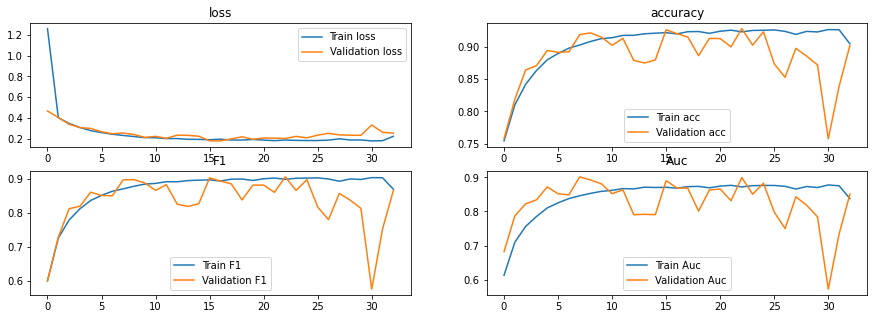

In [38]:
show_final_history(final_model_history1)